In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd  
import os
from datetime import datetime
from scipy import interpolate

from collections import Counter #might not be neccessary
from matplotlib import cm
from matplotlib import colors as c
from matplotlib.patches import Rectangle
import matplotlib.ticker as ticker
import matplotlib.patheffects as PathEffects
import matplotlib.patches as mpatches


import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torch.optim as optim
import torchvision
from torchvision import models

from torchsummary import summary

import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
print(device)

cpu


# Create Save File

In [3]:
# save of the day and iteration
# running the notebook multiple times creates individual folders for the results
today = datetime.now()
month_day = today.strftime("%m-%d")
try:
    os.mkdir(f'figures {month_day}')
    os.mkdir(f'figures {month_day}/1')
    folder_num = 1
except:
    num_folder = len(os.listdir(f'figures {month_day}'))
    folder_num = num_folder + 1
    os.mkdir(f'figures {month_day}/{folder_num}')   

# Load Data

In [4]:
# Inputting the data containing the manufacturing process langugage (MPL)
MPL = pd.read_csv("MFG_VAE_Dataset.csv")
MPL.index = MPL.loc[:, MPL.columns == "Process"].to_numpy()[:,0]
MPL1 = MPL
MPL.head()

,Process,MEC,COND,CONV,ELE,MAG,CHE,RAD,TIME_1,TIME_2,...,POLYMER,WOOD,CERAMIC,GLASS,GEOM_COM,TOOL_COST,EQUIP_COST,DEF,REM,ADD
Bending Hemming,Bending Hemming,3,0,0,0,0,0,0,0,2,...,0,0,0,0,2,2,1,1,0,0
Cold Continuous Extrusion,Cold Continuous Extrusion,2,0,0,0,0,0,0,0,2,...,0,0,0,0,2,3,3,1,0,0
Hot Open Die Forging,Hot Open Die Forging,3,2,1,0,0,0,1,3,5,...,0,0,0,0,1,3,3,1,0,0
Hot Closed Die Forging,Hot Closed Die Forging,4,3,1,0,0,0,1,2,3,...,0,0,0,0,2,3,4,1,0,0
Hot Rolling,Hot Rolling,2,2,2,0,0,0,1,1,2,...,0,0,0,0,1,2,2,1,0,0


In [5]:
x = MPL1.loc[:, MPL.columns != "Process"].to_numpy()
y = MPL1.loc[:, MPL.columns == "Process"].to_numpy()[:,0]
process_names = y
print("Number of Process Classes:", np.shape(x)[0]) 

Number of Process Classes: 55


In [6]:
# Creating process characteristic array
feature_labels = MPL1.drop(columns=["Process"])
print(feature_labels.columns)
print("Number of Process Characteristics:", len(feature_labels.columns))

Index(['MEC', 'COND', 'CONV', 'ELE', 'MAG', 'CHE', 'RAD', 'TIME_1', 'TIME_2',
       'VOL_CHANGE', 'VOL_1', 'VOL_2', 'TOOL_SPE', 'SURFQ_1', 'SURFQ_2',
       'IT_1', 'IT_2', 'MET', 'POLYMER', 'WOOD', 'CERAMIC', 'GLASS',
       'GEOM_COM', 'TOOL_COST', 'EQUIP_COST', 'DEF', 'REM', 'ADD'],
      dtype='object')
Number of Process Characteristics: 28


In [7]:
# Retriveing index number of each process characteristic
labels = feature_labels.columns

def feature_cat(labels):
    energy_inputs = ['MEC', 'COND', 'CONV', 'ELE', 'MAG', 'CHE', 'RAD']
    materials = ['MET', 'POLYMER', 'WOOD', 'CERAMIC', 'GLASS']
    tool_interaction = ['VOL_CHANGE', 'VOL_1', 'SURFQ_1', 'IT_1']
    productivity = ['TOOL_SPE', 'TIME_1', 'GEOM_COM', 'TOOL_COST', 'EQUIP_COST']
    
    return energy_inputs, materials, tool_interaction, productivity

def index_location(labels, DRA):
    # List of process characteristics
    energy_inputs, materials, tool_interaction, productivity = feature_cat(labels)
    
    if DRA ==1:
        processes = ['DEF', 'REM', 'ADD']
        indices = [labels.get_loc(label) for category in [energy_inputs, materials, tool_interaction, productivity, processes] for label in category]
    else:
        indices = [labels.get_loc(label) for category in [energy_inputs, materials, tool_interaction, productivity] for label in category]
        
    return tuple(indices)

In [8]:
energy_inputs, materials, tool_interaction, productivity = feature_cat(labels)
print(energy_inputs)

['MEC', 'COND', 'CONV', 'ELE', 'MAG', 'CHE', 'RAD']


In [9]:
labels = feature_labels.columns  # Assuming you have the labels available
MEC, COND, CONV, ELE, MAG, CHE, RAD, mat_metal, mat_polymer, mat_wood, mat_ceramic, mat_glass, vol_change, vol_affected, surface_qual, tolerance_IT, tool_special, process_time, geom_complex, tool_cost, equip_cost, def_process, rem_process, add_process = index_location(labels, 1)
print(tolerance_IT)

15


# Data Augmentation

In [10]:
# This cell splits the process time, affected volume, surface finsih, and IT Grade based on max min values.
# Each process is split into two versions; a small and large scale tool-workpiece interaction 
names_colum = []
parameters = []
group_number = []

# IF DATA AUGMENTATION ISN"T NEEDED, OPTION TO TURN OFF?
for num in range(0,x.shape[0]):
    # Need to automate this section to 'characteristic'_1_2
    # Currently done manually
    time_1_2  = range(x[num,process_time],x[num,process_time+1]+1)
    
    vol_1_2   = range(x[num,vol_affected],x[num,vol_affected+1]+1)
    
    IT_1_2    = range(x[num,tolerance_IT],x[num,tolerance_IT+1]+1)
    
    sq_1_2    = range(x[num,surface_qual],x[num,surface_qual+1]+1)

    for ee in range(2):
        # Need to update this section to automatically name and organize the ranges into the 'full' array
        # naming convention e.g. process_1 and process_2       
        names_colum.append([y[num]+'_'+str(ee+1)])
        
        # Creating the updated array for training
        # energy inputs range
        e_r  = x[num,MEC:RAD+1]
    
        # time range
        t_r  = [time_1_2[ee*-1]]
        
        # volume change
        v_c = x[num,vol_change:vol_change+1]      
      
        # volume range
        v_r   = [vol_1_2[ee*-1]]             
 
        # tool spec
        t_s = x[num,tool_special:tool_special+1]
        
        # surface quality range
        sq_r    = [sq_1_2[ee*-1]]
        
        # IT Grade range       
        IT_r = np.ravel(np.array(IT_1_2[ee*-1]))       
        
        # material range
        m_r = x[num,mat_metal:mat_glass+1]
        
        # geometric complexity
        g_c = x[num,geom_complex:geom_complex+1]
        
        # tool/equip cost range
        te_c = x[num,tool_cost:equip_cost+1]
        
        # DEF,REM,ADD
        d_r_a = x[num,def_process:add_process+1]
        full = np.concatenate((e_r,t_r,v_c,v_r,t_s,sq_r,IT_r,m_r,g_c,te_c,d_r_a))       
        
        parameters.append(full)
        group_number.append(num)

In [11]:
# Updating Index after removing the '_2' to confirm to Data Augmentation results
feature_labels = MPL1.drop(columns=["IT_2", "SURFQ_2", "VOL_2", "TIME_2", "DEF", "REM", "ADD","Process"])
labels = feature_labels.columns

MEC, COND, CONV, ELE, MAG, CHE, RAD, mat_metal, mat_polymer, mat_wood, mat_ceramic, mat_glass, vol_change, vol_affected, surface_qual, tolerance_IT, tool_special, process_time, geom_complex, tool_cost, equip_cost = index_location(labels,0)
print(tolerance_IT)

feature_index_array = np.array([
    MEC, COND, CONV, ELE, MAG, CHE, RAD,
    process_time, vol_change, vol_affected, tool_special, surface_qual, tolerance_IT,
    mat_metal, mat_polymer, mat_wood, mat_ceramic, mat_glass,
    geom_complex, tool_cost, equip_cost])

12


In [12]:
a = np.array(names_colum)
a.shape
# Updated array for process names
y2 = a.ravel()
print(y2.shape)

# Updated array for process features
x2 = np.array(parameters)
print(x2.shape)

(110,)
(110, 24)


In [13]:
# To avoid changing variable
x = x2
y = y2
print("Hemming", x[0,:])

Hemming [ 3  0  0  0  0  0  0  0  1  0  0  3 13  1  0  0  0  0  2  2  1  1  0  0]


In [14]:
# Organizing based on mode of interation
deformation = x[:,-3]
removal     = x[:,-2]
additive    = x[:,-1]
print(deformation[0])
print(removal[0])
print(additive[0])
# International Tolerance
IT_Grade = x[:,tolerance_IT]
# list of unique values used in dataset
IT_List = list(set(IT_Grade))

1
0
0


In [15]:
# # Removing whether its DEF, REM, ADD
x3 = x2[:,:-3]
x = x3
print(x.shape)
# Checking bending process
print(y[0],x[0,:])
print(y[1],x[1,:])

(110, 21)
Bending Hemming_1 [ 3  0  0  0  0  0  0  0  1  0  0  3 13  1  0  0  0  0  2  2  1]
Bending Hemming_2 [ 3  0  0  0  0  0  0  2  1  7  0  5 15  1  0  0  0  0  2  2  1]


In [16]:
# category normalization (makes a column within 0 & 1)
def norm_cat(input_x, original_x, inverse):
    x_norm =  []
    for e in range(len(feature_index_array)):
        chrs = input_x[:,e]
        og_x = original_x[:,e]
        
        if e<= 6:      
            max_val = 5
            min_val = 0
        else:
            max_val = np.max(og_x)
            min_val = np.min(og_x)
                
        if not inverse:
            x_column = (chrs - min_val) / (max_val - min_val)
        else:
            x_column = (chrs * (max_val - min_val)) + min_val
        x_norm.append(x_column)
    x_norm = np.transpose(np.array(x_norm))
    return x_norm      
x_norm = norm_cat(x3,x3,inverse=False)
x_invs = norm_cat(x_norm,x3,inverse=True)

def norm_element_inv(input_x, original_x, e):
    chrs = input_x
    og_x = original_x[:,e]
    if e<= 6:      
            max_val = 5
            min_val = 0
    else:
        max_val = np.max(og_x)
        min_val = np.min(og_x)
    x_element = (chrs * (max_val - min_val)) + min_val
    
    return x_element

In [17]:
print(x_norm.shape)

(110, 21)


In [18]:
print(y[1],x_norm[1,:])
print(y[1],x_invs[1,:])
print(y[1],x3[1,:])

Bending Hemming_2 [0.6        0.         0.         0.         0.         0.
 0.         0.33333333 0.5        0.63636364 0.         0.71428571
 0.92857143 1.         0.         0.         0.         0.
 0.66666667 0.5        0.        ]
Bending Hemming_2 [ 3.  0.  0.  0.  0.  0.  0.  2.  1.  7.  0.  5. 15.  1.  0.  0.  0.  0.
  2.  2.  1.]
Bending Hemming_2 [ 3  0  0  0  0  0  0  2  1  7  0  5 15  1  0  0  0  0  2  2  1]


In [19]:
# L2 Normilization
w = np.sqrt(sum(x_norm**2))
# w = np.sqrt(sum(x**2))
# input_vector = x/w
input_vector = x_norm/w

x = input_vector

In [20]:
# test
testt = input_vector[0,0]*w[0]
print(testt)

0.6


In [21]:
print(w)

[4.05955663 3.65513338 1.62480768 2.84253408 1.26491106 1.81107703
 3.38230691 5.49241902 5.52268051 4.75690016 5.83095189 5.17253343
 5.40596798 9.59166305 6.92820323 4.47213595 6.164414   7.07106781
 6.28932075 6.05185922 5.57773351]


In [22]:
print(w[0])

4.059556626036887


# UQ Network

In [23]:
### Work In Progress ###
### KL Loss needs up be updated ###
class Decoder_UQ(nn.Module):
    def __init__(self, latent_size, input_size, layer_size):
        super().__init__()
        
        self.lin1 = nn.Linear(latent_size, layer_size)
        self.relu1 = nn.ReLU(inplace=True)
        self.lin2 = nn.Linear(layer_size, layer_size)
        self.relu2 = nn.ReLU(inplace=True)
        self.lin3 = nn.Linear(layer_size, input_size)
        
    def forward(self, latent):
        reconstructed = self.lin1(latent)
        reconstructed = nn.functional.dropout(reconstructed, p=0.1, training=True)
        reconstructed = self.relu1(reconstructed)
        reconstructed = self.lin2(reconstructed)
        reconstructed = nn.functional.dropout(reconstructed, p=0.1, training=True)
        reconstructed = self.relu2(reconstructed)
        reconstructed = self.lin3(reconstructed)
        reconstructed = nn.functional.dropout(reconstructed, p=0.1, training=True)
        return reconstructed


class VariationalEncoder_UQ(nn.Module):
    def __init__(self, latent_size, input_size, layer_size):
        super(VariationalEncoder_UQ, self).__init__()
        self.linear1 = nn.Linear(input_size, layer_size)
        self.linear2 = nn.Linear(layer_size, latent_size)
        self.linear3 = nn.Linear(layer_size, latent_size)

        self.N = torch.distributions.Normal(0, 1)
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [24]:
class VariationalAutoencoder_UQ(nn.Module):
    def __init__(self, latent_size, input_size, layer_size):
        super(VariationalAutoencoder_UQ, self).__init__()
        self.encoder = VariationalEncoder_UQ(latent_size, input_size, layer_size)
        self.decoder = Decoder_UQ(latent_size, input_size, layer_size)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [25]:
# select either non-UQ (0) or UQ (1)
UQ = 0

# Network Design

In [26]:
batch_size = x.shape[1]
print(batch_size)

21


In [27]:
train_dataset = torch.utils.data.TensorDataset(torch.tensor(x, dtype=torch.float))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=False)

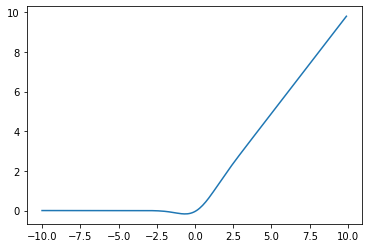

In [28]:
gelux = torch.arange(-10,10,0.1)
off = 0.1
geluy = 0.5*(gelux-off)*(1+torch.tanh(np.sqrt(2/np.pi)*(((gelux-off)+0.044715*(gelux-off)**3))))
# geluy = 0.5*(x-off)*(1+torch.tanh(np.sqrt(2/np.pi)*((x-off)+0.044715*(x-off)**3)))
plt.plot(gelux,geluy)
# print(geluy)

In [29]:
class GELU_limit(nn.Module):
    def __init__(self, max = np.max(input_vector), min = -0.01):
        super(GELU_limit, self).__init__()
        self.max = max
        self.min = min
    def forward(self, x):
        off = 0.1
        GELU_approx = (0.5*(x-off)*(1+torch.tanh(np.sqrt(2/np.pi)*((x-off)+0.044715*(x-off)**3))))*1.1
        return torch.clamp(GELU_approx, max = self.max)

In [30]:
class Encoder(nn.Module):
    def __init__(self, latent_size, input_size, layer_size):
        super().__init__()
        
        self.linear1   = nn.Linear(input_size, layer_size)
        
        self.linear2   = nn.Linear(layer_size, layer_size)
        
        self.linear3   = nn.Linear(layer_size, latent_size) # mean (µ)
        
        self.linear4   = nn.Linear(layer_size, latent_size) # log variance (σ)
        
        self.N = torch.distributions.Normal(0, 1)       
        self.kl = 0 # tracking the KL Loss

    def forward(self, x):
        x  = torch.flatten(x, start_dim=1)
        
        h  = F.leaky_relu_(self.linear1(x))
        h  = F.leaky_relu_(self.linear2(h))
        mu =  self.linear3(h) # mean vector
        sigma = torch.exp(0.5*self.linear4(h)) # standard deviation vector 
        z = mu + sigma* torch.randn_like(sigma)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum() # KL Loss 
        return z
    
    
class Decoder(nn.Module):
    def __init__(self, latent_size, input_size, layer_size):
        super().__init__()
        
        self.lin_decoder = nn.Sequential(
            nn.Linear(latent_size, layer_size),
            nn.LeakyReLU(),
            nn.Linear(layer_size, layer_size),
            nn.GELU(),
            nn.Linear(layer_size, input_size),
            GELU_limit()
        )
    def forward(self, latent):
        reconstructed = self.lin_decoder(latent)
        return reconstructed

In [31]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_size, input_size, layer_size):
        super().__init__()
        self.encoder = Encoder(latent_size, input_size, layer_size)
        self.decoder = Decoder(latent_size, input_size, layer_size)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if UQ == 1:
    model = VariationalAutoencoder_UQ(latent_size = 2, input_size = x.shape[1], layer_size = 16).to(device)
else:
    model = VariationalAutoencoder(latent_size = 2, input_size = x.shape[1], layer_size = 16).to(device)

summary(model, (1, x.shape[1]))

learning_rate = 4e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

criterion = nn.MSELoss()

Layer (type:depth-idx)                   Output Shape              Param #
├─Encoder: 1-1                           [-1, 2]                   --
|    └─Linear: 2-1                       [-1, 16]                  352
|    └─Linear: 2-2                       [-1, 16]                  272
|    └─Linear: 2-3                       [-1, 2]                   34
|    └─Linear: 2-4                       [-1, 2]                   34
├─Decoder: 1-2                           [-1, 21]                  --
|    └─Sequential: 2-5                   [-1, 21]                  --
|    |    └─Linear: 3-1                  [-1, 16]                  48
|    |    └─LeakyReLU: 3-2               [-1, 16]                  --
|    |    └─Linear: 3-3                  [-1, 16]                  272
|    |    └─GELU: 3-4                    [-1, 16]                  --
|    |    └─Linear: 3-5                  [-1, 21]                  357
|    |    └─GELU_limit: 3-6              [-1, 21]                  --
Total param

# Learning Procedure

In [33]:
# Tracking losses over epoch
losses    = []
kl_cyclic = 0.
kl_weight = 0.
epochs    = 250

## First Step

In [34]:
# Warming up the model by learning w/o KL Loss
for epoch in range(epochs):
    train_loss = 0.
    for batch_features, in train_loader:
 
        outputs = model(batch_features.to(device))

        MSE_loss = ((batch_features - outputs)**2).mean()

        loss_kl = model.encoder.kl/batch_size

        # Total Loss Recon + KL
        loss = (MSE_loss*(1-kl_weight)+loss_kl*kl_weight)
      
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        train_loss += loss.item()
    train_loss = train_loss / len(train_loader)
    losses.append(train_loss)
    if epoch % 10 == 0:
        print("epoch : {}/{},\t recon loss = {:.8f},\t KL Loss:{:.8f},\t MSE Loss:{:.8f}"
              .format(epoch + 1, epochs, train_loss, loss_kl, MSE_loss))

epoch : 1/250,	 recon loss = 0.01776150,	 KL Loss:0.25396115,	 MSE Loss:0.01281121
epoch : 11/250,	 recon loss = 0.00477223,	 KL Loss:0.22744176,	 MSE Loss:0.00460133
epoch : 21/250,	 recon loss = 0.00466895,	 KL Loss:0.33103889,	 MSE Loss:0.00457491
epoch : 31/250,	 recon loss = 0.00381698,	 KL Loss:1.71120417,	 MSE Loss:0.00464218
epoch : 41/250,	 recon loss = 0.00320047,	 KL Loss:2.35493517,	 MSE Loss:0.00356380
epoch : 51/250,	 recon loss = 0.00275937,	 KL Loss:1.99994338,	 MSE Loss:0.00261621
epoch : 61/250,	 recon loss = 0.00270859,	 KL Loss:3.56412363,	 MSE Loss:0.00228008
epoch : 71/250,	 recon loss = 0.00255673,	 KL Loss:2.69913602,	 MSE Loss:0.00286461
epoch : 81/250,	 recon loss = 0.00228327,	 KL Loss:2.83035827,	 MSE Loss:0.00252645
epoch : 91/250,	 recon loss = 0.00214266,	 KL Loss:2.64433718,	 MSE Loss:0.00197800
epoch : 101/250,	 recon loss = 0.00193774,	 KL Loss:3.43153930,	 MSE Loss:0.00142474
epoch : 111/250,	 recon loss = 0.00191026,	 KL Loss:2.79171872,	 MSE Loss:0.

## Second Step

In [35]:
# Maintain KL loss under a set threshold
kl_weight   = 0.

kl_active   = 0. # counts number of times kl weight is activated
kl_inactive = 0

for epoch in range(epochs):
    train_loss = 0.    
    for batch_features, in train_loader:
        
        outputs = model(batch_features.to(device))

        MSE_loss = ((batch_features - outputs)**2).mean()

        loss_kl = model.encoder.kl/batch_size
        
        # Minimizing KL loss when above threshold
        if loss_kl >= 1.0:
            kl_weight = 5e-3
            kl_active +=1
        else:
            kl_weight = 0.0    
            kl_inactive +=1
            
        loss = (MSE_loss*(1-kl_weight)+loss_kl*kl_weight)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        train_loss += loss.item()
        
    train_loss = train_loss / len(train_loader)
    losses.append(train_loss)
    if epoch % 10 == 0:
        print("epoch : {}/{},\t recon loss = {:.8f},\t KL Loss:{:.8f},\t MSE Loss:{:.8f}"
              .format(epoch + 1, epochs, train_loss, loss_kl, MSE_loss))

epoch : 1/250,	 recon loss = 0.05535630,	 KL Loss:1.57072282,	 MSE Loss:0.00279913
epoch : 11/250,	 recon loss = 0.00475402,	 KL Loss:0.18056497,	 MSE Loss:0.00453549
epoch : 21/250,	 recon loss = 0.00461926,	 KL Loss:0.18529178,	 MSE Loss:0.00426406
epoch : 31/250,	 recon loss = 0.00531445,	 KL Loss:0.20706476,	 MSE Loss:0.00329740
epoch : 41/250,	 recon loss = 0.00467830,	 KL Loss:0.24687211,	 MSE Loss:0.00527634
epoch : 51/250,	 recon loss = 0.00425492,	 KL Loss:0.20623307,	 MSE Loss:0.00258356
epoch : 61/250,	 recon loss = 0.00441750,	 KL Loss:0.21740319,	 MSE Loss:0.00340243
epoch : 71/250,	 recon loss = 0.00517807,	 KL Loss:0.19826606,	 MSE Loss:0.00385056
epoch : 81/250,	 recon loss = 0.00498478,	 KL Loss:0.20750493,	 MSE Loss:0.00315714
epoch : 91/250,	 recon loss = 0.00605566,	 KL Loss:0.21317963,	 MSE Loss:0.00414608
epoch : 101/250,	 recon loss = 0.00586070,	 KL Loss:0.18738040,	 MSE Loss:0.00312855
epoch : 111/250,	 recon loss = 0.00589160,	 KL Loss:0.18723576,	 MSE Loss:0.

## Third Step

In [36]:
for g in optimizer.param_groups:
    g['lr'] = 5e-3

In [37]:
# A diminishing KL Weight is utilized to 
kl_weight = 0.0
kl_cyclic = 0.
epochs =  500
for epoch in range(epochs):
    train_loss = 0.
    for batch_features, in train_loader:
        
        # Diminishing KL weight 
        kl_weight = 0.01/((epoch+1))
        
        outputs = model(batch_features.to(device))

        MSE_loss = ((batch_features - outputs)**2).mean()
        
        loss_kl = model.encoder.kl/batch_size
        
        loss = (MSE_loss*(1-kl_weight)+loss_kl*kl_weight)
              
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()       
        
    train_loss = train_loss / len(train_loader)
    losses.append(train_loss)
    if epoch % 10 == 0:
        print("epoch : {}/{},\t recon loss = {:.8f},\t KL Loss:{:.8f},\t MSE Loss:{:.8f}"
              .format(epoch + 1, epochs, train_loss, loss_kl, MSE_loss))

epoch : 1/500,	 recon loss = 0.01273896,	 KL Loss:0.19354685,	 MSE Loss:0.00540597
epoch : 11/500,	 recon loss = 0.00470513,	 KL Loss:0.28407782,	 MSE Loss:0.00317299
epoch : 21/500,	 recon loss = 0.00433311,	 KL Loss:0.23063385,	 MSE Loss:0.00413415
epoch : 31/500,	 recon loss = 0.00384522,	 KL Loss:0.29262337,	 MSE Loss:0.00292296
epoch : 41/500,	 recon loss = 0.00345810,	 KL Loss:0.69982553,	 MSE Loss:0.00261198
epoch : 51/500,	 recon loss = 0.00326112,	 KL Loss:0.65151578,	 MSE Loss:0.00305013
epoch : 61/500,	 recon loss = 0.00316689,	 KL Loss:0.43163890,	 MSE Loss:0.00286212
epoch : 71/500,	 recon loss = 0.00304255,	 KL Loss:0.54837561,	 MSE Loss:0.00289339
epoch : 81/500,	 recon loss = 0.00292650,	 KL Loss:0.54237157,	 MSE Loss:0.00293391
epoch : 91/500,	 recon loss = 0.00297779,	 KL Loss:0.62312239,	 MSE Loss:0.00339292
epoch : 101/500,	 recon loss = 0.00271592,	 KL Loss:0.96997297,	 MSE Loss:0.00240367
epoch : 111/500,	 recon loss = 0.00257308,	 KL Loss:0.77980286,	 MSE Loss:0.

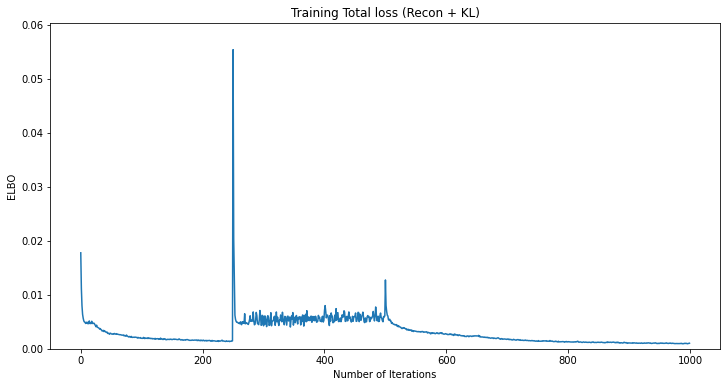

Percetage of KL Activation in Step '2' 31.23359580052493


In [38]:
plt.figure(figsize=(12,6))
plt.title("Training Total loss (Recon + KL)")
plt.ylim(0,np.max(losses)+0.005)
font_size = 18
font = {'family' : 'arial' ,
'weight' : 'normal',
'size'   : font_size}
plt.rc('font', **font)
plt.plot(losses)
plt.xlabel("Number of Iterations")
plt.ylabel("ELBO")
plt.savefig(f'figures {month_day}/{folder_num}/Loss Function.png')
plt.show()
print("Percetage of KL Activation in Step '2'", kl_active/kl_inactive*100)

In [39]:
# df= huigk?

# Input Space Representation Analysis

In [40]:
model_encoder = model.encoder
model_decoder = model.decoder
# saving the learnt model
torch.save(model_encoder, f'figures {month_day}/{folder_num}/model_encoder.pt')
torch.save(model_decoder, f'figures {month_day}/{folder_num}/model_decoder.pt')

In [41]:
# Latent set to two dimensions
latent = model_encoder(torch.tensor(input_vector, dtype=torch.float).to(device)).detach().cpu().numpy()
latent_vector = latent
print(latent_vector.shape)

(110, 2)


In [42]:
from scipy.spatial.distance import pdist, squareform
import numpy as np

def distcorr(X, Y):
    X = np.atleast_1d(X)
    Y = np.atleast_1d(Y)
    if np.prod(X.shape) == len(X):
        X = X[:, None]
    if np.prod(Y.shape) == len(Y):
        Y = Y[:, None]
    X = np.atleast_2d(X)
    Y = np.atleast_2d(Y)
    n = X.shape[0]
    if Y.shape[0] != X.shape[0]:
        raise ValueError('Number of samples must match')
    a = squareform(pdist(X))
    b = squareform(pdist(Y))
    A = a - a.mean(axis=0)[None, :] - a.mean(axis=1)[:, None] + a.mean()
    B = b - b.mean(axis=0)[None, :] - b.mean(axis=1)[:, None] + b.mean()
    
    dcov2_xy = (A * B).sum()/float(n * n)
    dcov2_xx = (A * A).sum()/float(n * n)
    dcov2_yy = (B * B).sum()/float(n * n)
    dcor = np.sqrt(dcov2_xy)/np.sqrt(np.sqrt(dcov2_xx) * np.sqrt(dcov2_yy))
    return dcor

In [43]:
distcorr(input_vector, latent_vector)

0.7991494697984289

# 2D Plotting

In [44]:
df = pd.DataFrame()
df["y"] = y
df["latent_dim_1"] = latent[:,0]
df["latent_dim_2"] = latent[:,1]
df["Group Number"] = group_number

df["Removal"] = removal
df["Deformation"] = deformation
df["Additive"] = additive

print(df)

                               y  latent_dim_1  latent_dim_2  Group Number  \
0              Bending Hemming_1      0.425947      0.772215             0   
1              Bending Hemming_2      0.679645      0.786193             0   
2    Cold Continuous Extrusion_1      0.342440      0.776731             1   
3    Cold Continuous Extrusion_2      0.554438      0.767765             1   
4         Hot Open Die Forging_1      0.114979     -0.595733             2   
..                           ...           ...           ...           ...   
105     Waterjet laser forming_2     -1.249842     -0.149511            52   
106    Resing Transfer Molding_1     -0.423270      1.396265            53   
107    Resing Transfer Molding_2     -0.511357      1.386184            53   
108            Robotic Welding_1      1.127357     -1.063969            54   
109            Robotic Welding_2      1.029128     -1.083603            54   

     Removal  Deformation  Additive  
0          0            1

In [45]:
latent_x = latent[:,0]
latent_y = latent[:,1]

In [46]:
a = Counter(group_number)
# print(a)
value = []
cc = 0
for c in range(0,len(a)):
    cc += a[c]
    value.append(cc)
print(value)

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110]


## Plotting based on centroid 

In [47]:
centroid_coor = []
x_center = []
y_center = []

cc = 0

for c in range(len(a)):
    ratio = a[c]
    cc += a[c]

    x_avg = np.array(latent_x[cc - a[c]:cc])
    y_avg = np.array(latent_y[cc - a[c]:cc])

    avg_coor = [np.sum(x_avg) / ratio, np.sum(y_avg) / ratio]
    centroid_coor.append(avg_coor)

    x_center.append(avg_coor[0])
    y_center.append(avg_coor[1])

value = np.cumsum(a).tolist()

In [48]:
# New dataframe for the centroid values
dd = pd.DataFrame()
dd["Process"] = process_names
dd["latent_x_avg"] = x_center
dd["latent_y_avg"] = y_center
# print(dd)

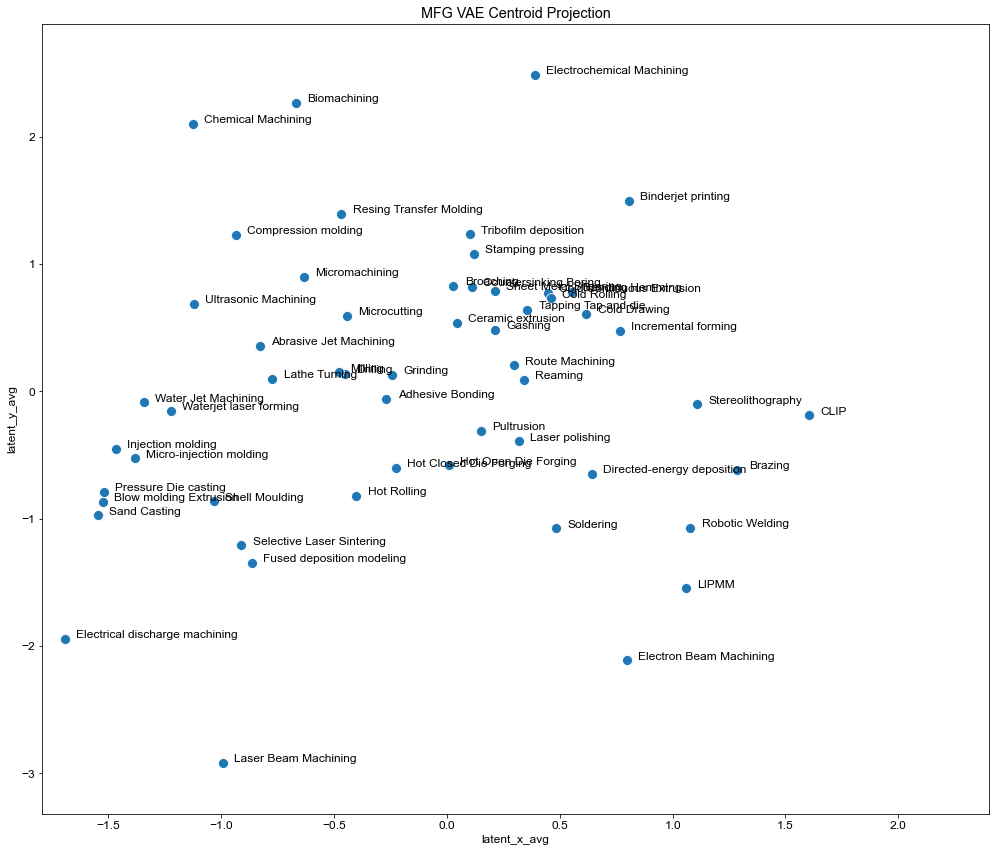

In [49]:
# Plotting the centroid locaiton of processes
font_size = 12
font = {'family' : 'arial' ,
'weight' : 'normal',
'size'   : font_size}

plt.rc('font', **font)
fig, ax = plt.subplots(figsize=(14,12))
plt.rcParams["figure.figsize"] = [10, 2]
plt.rcParams["figure.autolayout"] = False

sns.scatterplot(x="latent_x_avg", y="latent_y_avg",s=100,
                data=dd).set(title="MFG VAE Centroid Projection") 

plt.xlim(dd["latent_x_avg"].min()-0.1,dd["latent_x_avg"].max()+0.8)    

plt.ylim(dd["latent_y_avg"].min()-0.4,dd["latent_y_avg"].max()+0.4) 


for i, process in enumerate (process_names):
    plt.annotate(process, (x_center[i]+0.05, y_center[i]+0.01) )
    
plt.tight_layout()
plt.savefig(f'figures {month_day}/{folder_num}/Latent Space Plot.png')
plt.show()

# Checking Reconstruction Accuracy

## Rounding before decoding

In [50]:
check_recon_round = np.zeros(feature_index_array.shape)
test_processes_round = [] 
# test_processes_round_test = np.zeros_like(feature_index_array,dtype=float)

all_latents    = np.column_stack([latent_x, latent_y])
original_recon = model_decoder(torch.tensor(all_latents, dtype=torch.float).to(device)).detach().cpu().numpy()
rounded_recon  = []

def round_array_with_thresholds(arr, threshold):
    return np.where(arr < threshold / 2.0, 0.0, np.around(arr / threshold - 0.0) * threshold)

for e in range(len(feature_index_array)):
    # the threshold value for each weight from L2 normalization
    threshold = np.unique(input_vector[:,e])[1:]
    # each column of a feature is split   
    feature_column = original_recon[:,e].reshape(len(y2),1)
#     print(feature_column[0])
    temp_rounded_array = np.array([round_array_with_thresholds(sequence, threshold) for sequence in feature_column[:]])
#     print(temp_rounded_array[0,0])
#     test_processes_round_test[e] = temp_rounded_array
    
    test_processes_round.append(temp_rounded_array[:,0].reshape(len(y2),1))
    if e == tolerance_IT:
        print('predicted', np.max(temp_rounded_array[:,0].reshape(len(y2),1)))
        print('actual', len(np.unique(input_vector[:len(y2),e].reshape(len(y2),1))))
    Subtract = np.count_nonzero(temp_rounded_array[:,0].reshape(len(y2),1) - input_vector[:len(y2),e].reshape(len(y2),1))
    if e == tolerance_IT:
        print(Subtract)
    check_recon_round[e] = Subtract
    rounded_recon.append(Subtract)
    
# MSE_error = calculate_mse(y_vala, y_pred)


accuracy_round = 1 - np.sum(rounded_recon)/2200

print("Number of Misclassifications:", np.sum(rounded_recon))
print("Accuracy", accuracy_round)
for e in range(len(feature_index_array)):
    print("{}:   \t{:.1f}".format(labels[e], check_recon_round[e]))

predicted 0.158554926774507
actual 15
101
Number of Misclassifications: 628
Accuracy 0.7145454545454546
MEC:   	49.0
COND:   	24.0
CONV:   	0.0
ELE:   	10.0
MAG:   	2.0
CHE:   	8.0
RAD:   	25.0
TIME_1:   	67.0
VOL_CHANGE:   	7.0
VOL_1:   	95.0
TOOL_SPE:   	4.0
SURFQ_1:   	81.0
IT_1:   	101.0
MET:   	10.0
POLYMER:   	12.0
WOOD:   	0.0
CERAMIC:   	1.0
GLASS:   	5.0
GEOM_COM:   	33.0
TOOL_COST:   	53.0
EQUIP_COST:   	41.0


In [54]:
def calc_diff(y_vala, y_pred, feature_index_array, labels):
    max_diff = np.zeros(feature_index_array.shape)
    min_diff = np.zeros(feature_index_array.shape)
    mean_diff = np.zeros(feature_index_array.shape)
    std_diff = np.zeros(feature_index_array.shape)

    for e in range(len(feature_index_array)):
        diff_temp = y_vala[:, e] - y_pred[:, e]

        max_diff[e] = np.max(diff_temp)
        min_diff[e] = np.min(diff_temp)
        mean_diff[e] = np.mean(np.abs(diff_temp))
        std_diff[e] = np.std(diff_temp)

    for e in range(len(feature_index_array)):
        print("{}:MAX:\t{:.1f} MIN:\t{:.1f} MEAN:\t{:.1f} STD:\t{:.1f}".format(labels[e], max_diff[e], min_diff[e], mean_diff[e], std_diff[e]))
        
def calc_diff_single(y_vala, y_pred, feature_index_array, e):
    diff_temp = y_vala[:, e] - y_pred[:, e]
    mean_diff = np.mean(np.abs(diff_temp))
    std_diff = np.std(diff_temp)
    
    return mean_diff, std_diff

def feature_correction(temp_feature, mean, std, k):
    z = (temp_feature-mean)/std
    corrected_temp_feature = temp_feature-k*std#*z
    return corrected_temp_feature


## Rounding after decoding

In [56]:
def calculate_mse(y_true, y_pred):
    return np.square(np.subtract(y_true, y_pred)).mean()

def calculate_accuracy(check_recon, total_elements):
    return 1 - check_recon.sum() / total_elements

def print_results(labels, check_recon):
    for e, label in enumerate(labels):
#         e = e-1
        print("{}:\t{:.1f}".format(label, check_recon[e]))

labels = feature_labels.columns

check_recon = np.zeros(feature_index_array.shape)

all_latents = np.column_stack([latent_x, latent_y])

if len(latent_vector[1]) == 3:
    all_latents = np.column_stack([latent_x, latent_y, latent_z])

test_processes = model_decoder(torch.tensor(all_latents, dtype=torch.float).to(device)).detach().cpu().numpy()

# y_vala = x * w
y_vala = x3
y_pre1  = w * test_processes
y_pre2  = norm_cat(y_pre1,x3,inverse=True)

print(input_vector[0,0])
print(test_processes[0,0])
print(y_pre1[0,0])
print(x_norm[0,0])
print(y_pre2[0,0])

y_pred = np.around(y_pre2)

check_recon += np.sum(y_pred != y_vala, axis=0)

MSE_error = calculate_mse(y_vala, y_pred)
accuracy  = calculate_accuracy(check_recon, y_pred.size)

print("Number of Misclassifications:", check_recon.sum())
print("Accuracy", accuracy)
print("MSE Error", MSE_error)

print_results(labels, check_recon)

0.14779939172464399
0.08478405
0.3441856652184513
0.6
1.7209283260922565
Number of Misclassifications: 582.0
Accuracy 0.7480519480519481
MSE Error 0.7688311688311689
MEC:	41.0
COND:	24.0
CONV:	0.0
ELE:	9.0
MAG:	0.0
CHE:	2.0
RAD:	15.0
TIME_1:	67.0
VOL_CHANGE:	7.0
VOL_1:	86.0
TOOL_SPE:	4.0
SURFQ_1:	81.0
IT_1:	91.0
MET:	10.0
POLYMER:	12.0
WOOD:	0.0
CERAMIC:	1.0
GLASS:	5.0
GEOM_COM:	33.0
TOOL_COST:	53.0
EQUIP_COST:	41.0


In [57]:
for e in range(len(feature_index_array)):
    mean, std = calc_diff_single(y_vala, y_pre2,feature_index_array, e)
    
    corrected_feature = feature_correction(testt,mean,std,k=0.5)


In [58]:
num_metal_wrong = np.sum(y_pred[:,tolerance_IT] != y_vala[:,tolerance_IT])
print(num_metal_wrong)

91


In [60]:
calc_diff(y_vala, y_pre2, feature_index_array, labels)

MEC:MAX:	1.7 MIN:	-1.1 MEAN:	0.5 STD:	0.6
COND:MAX:	1.4 MIN:	-1.1 MEAN:	0.3 STD:	0.5
CONV:MAX:	0.4 MIN:	-0.4 MEAN:	0.1 STD:	0.1
ELE:MAX:	0.7 MIN:	-0.6 MEAN:	0.1 STD:	0.2
MAG:MAX:	0.4 MIN:	-0.4 MEAN:	0.1 STD:	0.1
CHE:MAX:	0.7 MIN:	-0.3 MEAN:	0.1 STD:	0.1
RAD:MAX:	1.8 MIN:	-1.4 MEAN:	0.3 STD:	0.5
TIME_1:MAX:	3.6 MIN:	-2.6 MEAN:	0.8 STD:	1.1
VOL_CHANGE:MAX:	0.9 MIN:	-0.5 MEAN:	0.2 STD:	0.3
VOL_1:MAX:	5.7 MIN:	-5.8 MEAN:	1.6 STD:	2.1
TOOL_SPE:MAX:	0.8 MIN:	-0.3 MEAN:	0.1 STD:	0.2
SURFQ_1:MAX:	3.3 MIN:	-3.4 MEAN:	1.0 STD:	1.2
IT_1:MAX:	6.1 MIN:	-5.7 MEAN:	1.9 STD:	2.4
MET:MAX:	0.6 MIN:	-0.8 MEAN:	0.2 STD:	0.3
POLYMER:MAX:	0.7 MIN:	-0.6 MEAN:	0.2 STD:	0.3
WOOD:MAX:	0.2 MIN:	-0.3 MEAN:	0.0 STD:	0.1
CERAMIC:MAX:	0.4 MIN:	-0.5 MEAN:	0.2 STD:	0.2
GLASS:MAX:	0.3 MIN:	-0.7 MEAN:	0.2 STD:	0.2
GEOM_COM:MAX:	1.0 MIN:	-1.1 MEAN:	0.4 STD:	0.4
TOOL_COST:MAX:	1.4 MIN:	-1.6 MEAN:	0.5 STD:	0.6
EQUIP_COST:MAX:	1.7 MIN:	-1.4 MEAN:	0.5 STD:	0.6


# New Processes

In [61]:
# Manually slecting points to decode process characteristics
X_COR0 = -1.1
Y_COR0 = 1.6
    
X_COR1 = 0.45
Y_COR1 = 0.52

X_COR2 = -1.2
Y_COR2 = -1.1

X_COR3 = 1.0
Y_COR3 = -1.65

COR0 = (X_COR0,  Y_COR0)
COR1 = (X_COR1, Y_COR1)
COR2 = (X_COR2, Y_COR2)
COR3 = (X_COR3, Y_COR3)

In [104]:
# Plot colored-coded based on volume change
def process_distribution(COR0,COR1,COR2,COR3,label):
    plt.figure(figsize=(11,8))
    if label>0:
        font_size = 40
        font = {'family' : 'arial' ,
        'weight' : 'normal',
        'size'   : font_size}
        plt.rc('font', **font)
        
        
        zoom_in = 6.0
        fig, ax = plt.subplots(figsize=(18,12))
        mode = (MPL.loc[:, MPL.columns == "DEF"].to_numpy() + 
             2 * MPL.loc[:, MPL.columns == "REM"].to_numpy() + 
             3 * MPL.loc[:, MPL.columns == "ADD"].to_numpy())
        ax = sns.scatterplot(x="latent_x_avg", y="latent_y_avg",s=400*zoom_in,
            hue = mode[:,0].tolist(),
            palette=sns.color_palette("husl", 3),  
            data=dd) 

        
#         for i, process in enumerate (process_names):
#             plt.annotate(process, (x_center[i]-0.08, y_center[i]+0.04) )
        
        
        
    else:
        font_size = 40
        font = {'family' : 'arial' ,
        'weight' : 'normal',
        'size'   : font_size}
        plt.rc('font', **font)
        fig, ax = plt.subplots(figsize=(12,11))
        mode = (df.loc[:, df.columns == "Deformation"].to_numpy() + 
             2 * df.loc[:, df.columns == "Removal"].to_numpy() + 
             3 * df.loc[:, df.columns == "Additive"].to_numpy())
#         ax = sns.scatterplot(x="latent_dim_1", y="latent_dim_2", s=200,
#             hue = mode[:,0].tolist(),
#             palette=sns.color_palette("husl", 3),
#             data=df)
        
        ax = sns.scatterplot(x="latent_dim_1", y="latent_dim_2", s=200,
            data=df)
         
         
        
            
        zoom_in = 1

    plt.rcParams["figure.figsize"] = [10, 2]
    plt.rcParams["figure.autolayout"] = False
    

    or_size = 400*zoom_in


    cor_data = [COR0, COR1, COR2, COR3]
    label_iterator = iter("ABCD")

    marker_size = or_size
    marker_color = 'orange'
    marker_edgecolor = 'white'
    marker_type = "X"

    if label >0:
        
        X,Y = cor_data[label-1]
        plt.scatter(X, Y, c=marker_color, s=marker_size, edgecolors=marker_edgecolor, marker=marker_type)
#         plt.text(X-0.1, Y+0.1, label) 
        X_Origin, Y_Origin = X-0.25, Y
        currentAxis = plt.gca()
        currentAxis.add_patch(Rectangle((X_Origin - .49, Y_Origin - .74), 1.48, 1.48, facecolor="none", ec='orange', lw=2, linestyle = '--'))

        plt.xlim([X-0.75, X+0.75])
        plt.ylim([Y-0.75, Y+0.75])
        currentAxis = plt.gca()

        
    else:
        for X, Y in cor_data:
#             plt.scatter(X, Y, c=marker_color, s=marker_size, edgecolors=marker_edgecolor, marker=marker_type)
            label_name = next(label_iterator) + '.'

            X_Origin, Y_Origin = X-0.25, Y
            currentAxis = plt.gca()
#             currentAxis.add_patch(Rectangle((X_Origin - .49, Y_Origin - .74), 1.48, 1.48, facecolor="none", ec='orange', lw=2, linestyle = '--'))
#             plt.text(X_Origin-0.5, Y_Origin+0.8, label_name)
    handles, labels  =  ax.get_legend_handles_labels()
    ax.legend(handles, ['Deformation', 'Removal', 'Additive'], loc = 2, fontsize="30")
    ax.get_legend().remove()
    



    plt.tight_layout()
    plt.xlabel("Latent Dimension 1") 
    plt.ylabel("Latent Dimension 2") 
    if label >0:
        plt.title(f'[{X}, {Y}]')
        for axis in [ax.xaxis, ax.yaxis]:
            axis.set_major_locator(ticker.MultipleLocator(0.5))
        plt.savefig(f'figures {month_day}/{folder_num}/MPL VAE MOI_{label}.png')
    else:
        
        plt.title("Manufacturing Process Distribution")
    
        plt.savefig(f'figures {month_day}/{folder_num}/MPL VAE MOI.png')
    
#     plt.xlim([-3.0, 1.8])
#     plt.ylim([-2.5, 2])
    
    plt.xlim([-3, 3])
    plt.ylim([-3, 3])
    plt.show()

<Figure size 792x576 with 0 Axes>

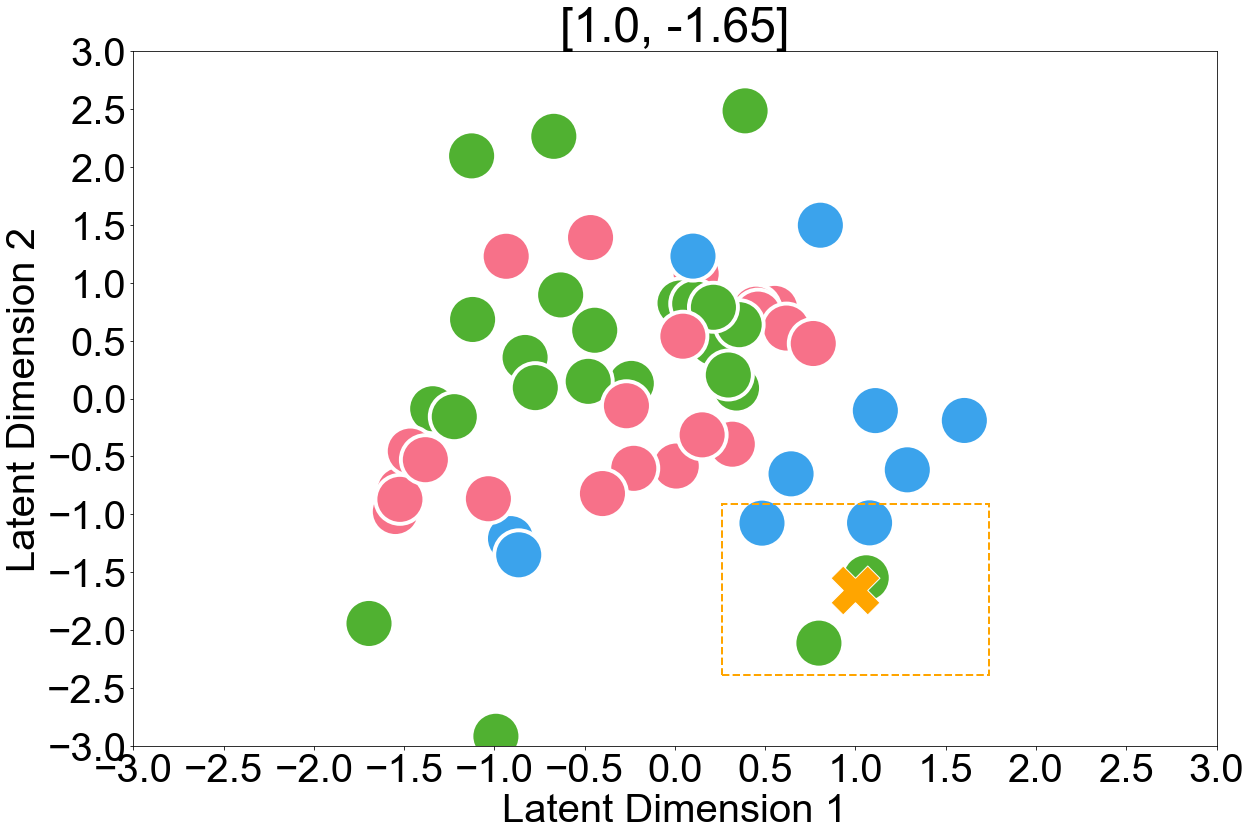

In [105]:
process_distribution(COR0,COR1,COR2,COR3,4)

<Figure size 792x576 with 0 Axes>

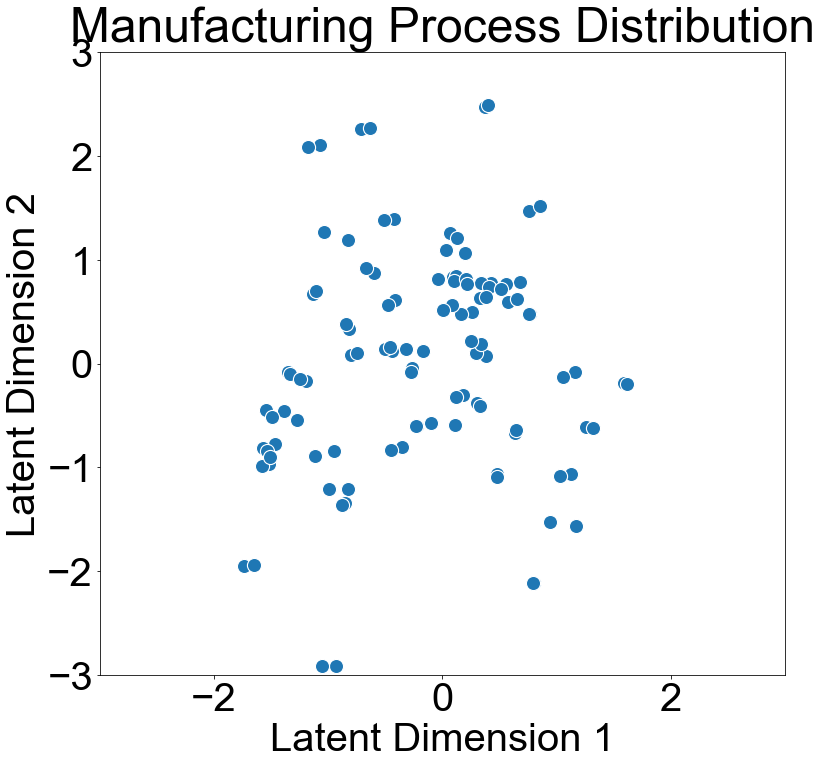

In [106]:
process_distribution(COR0,COR1,COR2,COR3,0)

In [65]:
labels = feature_labels.columns

def process_char(cor_data, label_iterator):
    for X, Y in cor_data:
        label = next(label_iterator) + '.'
        G_P = (model_decoder(torch.tensor((X, Y), dtype=torch.float).to(device)).detach().cpu().numpy())       
        temp_features_pro = np.zeros_like(feature_index_array,dtype=float) 
        
        for e in range(len(feature_index_array)):
            temp_features_pro[e] = G_P[e] * w[e]
            temp_features_pro[e] = norm_element_inv(temp_features_pro[e], x3, e)
        
        print(temp_features_pro)
        temp_features_pro = np.around(temp_features_pro)
        print(temp_features_pro)
        print("Process {} ----------------".format(label))                  
        for e in range(len(feature_index_array)):
            if e == process_time:
                print("{}:   \t{:.1f} s".format(labels[e], 10**(temp_features_pro[e]-1)))

            elif e == vol_affected:
                print("{}:   \t{:.1f} mm\u00b3".format(labels[e], 10**(temp_features_pro[e]-3)))

            elif e == surface_qual:
                print("{}:   \t{:.1f} nm".format(labels[e], 10**(temp_features_pro[e])))              
            else:
                print("{}:   \t{:.1f}".format(labels[e], temp_features_pro[e]))

In [66]:
test_try = model_decoder(torch.tensor(COR0, dtype=torch.float).to(device)).detach().cpu().numpy()
temp_features_pro = np.zeros_like(feature_index_array,dtype=float) 
for e in range(len(feature_index_array)):
    temp_features_pro[e] = test_try[e] * w[e]
    temp_features_pro[e] = norm_element_inv(temp_features_pro[e], x3, e)
print(np.around(temp_features_pro))

[ 1.  0. -0. -0. -0.  2.  0.  5.  1.  7.  1.  4.  8.  0.  1. -0.  1.  1.
  2.  1.  2.]


In [67]:
cor_data = [COR0, COR1, COR2, COR3]

label_iterator = iter("ABCD")

process_char(cor_data, label_iterator)

[ 1.01252128  0.34522427 -0.13697695 -0.25527818 -0.0248023   2.2348266
  0.16181031  4.66782887  0.98282853  6.75144759  1.17929519  3.84414701
  8.10157567  0.17515074  0.80089026 -0.04835827  0.57686664  1.0544326
  1.72072037  1.10550086  1.50883202]
[ 1.  0. -0. -0. -0.  2.  0.  5.  1.  7.  1.  4.  8.  0.  1. -0.  1.  1.
  2.  1.  2.]
Process A. ----------------
MEC:   	1.0
COND:   	0.0
CONV:   	-0.0
ELE:   	-0.0
MAG:   	-0.0
CHE:   	2.0
RAD:   	0.0
TIME_1:   	10000.0 s
VOL_CHANGE:   	1.0
VOL_1:   	10000.0 mm³
TOOL_SPE:   	1.0
SURFQ_1:   	10000.0 nm
IT_1:   	8.0
MET:   	0.0
POLYMER:   	1.0
WOOD:   	-0.0
CERAMIC:   	1.0
GLASS:   	1.0
GEOM_COM:   	2.0
TOOL_COST:   	1.0
EQUIP_COST:   	2.0
[ 1.88144247e+00  1.32840898e-01 -1.41683083e-01 -1.86605411e-02
 -6.75632577e-02  2.16089025e-02  7.77868097e-03  1.90858150e+00
  4.84173885e-01  4.22255227e+00  1.81192501e-01  2.88887575e+00
  8.08578346e+00  7.74616296e-01  5.68626704e-01  1.85910929e-02
  5.63796414e-01  1.59886941e-01  8.6065

# Latent Heat Maps

In [68]:
df.to_excel('process_list1.xlsx')

In [69]:
res = 500
num_instances = 500
instances = {}

In [70]:
# To develop the heat map, the mapping of the entire plot needs to be generated based on the
# max and mins of the latent dimensions
ext = 1.5
x_limit_min = df["latent_dim_1"].min()-ext
x_limit_max = df["latent_dim_1"].max()+ext

y_limit_min = df["latent_dim_2"].min()-ext
y_limit_max = df["latent_dim_2"].max()+ext

y_range = np.linspace(y_limit_min, y_limit_max, res)
x_range = np.linspace(x_limit_min, x_limit_max, res)

In [71]:
# Creating empty matrix for each feature
res_matrix = np.zeros((res, res), dtype=float)

mechanical_grid = np.zeros((res, res), dtype=float) #0
conduction_grid = np.zeros((res, res), dtype=float) #1
convection_grid = np.zeros((res, res), dtype=float) #2
electrical_grid = np.zeros((res, res), dtype=float) #3
magnetic_grid   = np.zeros((res, res), dtype=float) #4
chemical_grid   = np.zeros((res, res), dtype=float) #5
radiation_grid  = np.zeros((res, res), dtype=float) #6

# max_time_grid = np.zeros((res, res), dtype=float)
time_per_grid   = np.zeros((res, res), dtype=float) #7
vol_per_grid    = np.zeros((res, res), dtype=float) #8
vol_change_grid = np.zeros((res, res), dtype=float) #9
tool_spec_grid  = np.zeros((res, res), dtype=float) #10
surf_qual_grid   = np.zeros((res, res), dtype=float) #11
IT_grade_grid   = np.zeros((res, res), dtype=float) #12

mat_metal_grid   = np.zeros((res, res), dtype=float) #13
mat_polymer_grid    = np.zeros((res, res), dtype=float) #14
mat_wood_grid    = np.zeros((res, res), dtype=float) #15
mat_ceramic_grid = np.zeros((res, res), dtype=float) #16
mat_glass_grid   = np.zeros((res, res), dtype=float) #17
geo_complex_grid = np.zeros((res, res), dtype=float) #18

tool_cost_grid = np.zeros((res, res), dtype=float) #19
equipment_cost_grid = np.zeros((res, res), dtype=float) #20

In [72]:
X_latent, Y_latent = np.meshgrid(x_range, y_range)
print(X_latent.shape)
print(Y_latent.shape)

(500, 500)
(500, 500)


In [73]:
feature_index_array

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

# Raw Heat Maps 

In [74]:
# Dictionary to map feature_index_array indexes to corresponding grid names
grid_mapping = {
    MEC: mechanical_grid,
    COND: conduction_grid,
    CONV: convection_grid,
    ELE: electrical_grid,
    MAG: magnetic_grid,
    CHE: chemical_grid,
    RAD: radiation_grid,
    
    process_time: time_per_grid,
    vol_change:   vol_change_grid,
    vol_affected: vol_per_grid,
    tool_special: tool_spec_grid,
    surface_qual: surf_qual_grid,
    tolerance_IT: IT_grade_grid,
    
    mat_metal:   mat_metal_grid,
    mat_polymer: mat_polymer_grid,
    mat_wood:    mat_wood_grid,
    mat_ceramic: mat_ceramic_grid,
    mat_glass:   mat_glass_grid,
    
    geom_complex: geo_complex_grid,
    tool_cost:    tool_cost_grid,
    equip_cost:   equipment_cost_grid,
}

In [75]:
for i in range(len(X_latent)):
    for j in range(len(X_latent)):
        X = X_latent[i, j]
        Y = Y_latent[i, j]
        latent_heat = [X, Y]

        new_processes = model_decoder(torch.tensor(latent_heat, dtype=torch.float).to(device)).detach().cpu().numpy()

        temp_features = np.zeros_like(feature_index_array,dtype=float)

        for e in range(len(feature_index_array)):
            # rounding before inverse normusing thresholds
#             threshold = np.unique(input_vector[:,e])[1:]
#             feature_column = new_processes[e].reshape(1,1)           
#             temp_rounded_array = np.array([round_array_with_thresholds(sequence, threshold) for sequence in feature_column[:]])
#             rounded_val = temp_rounded_array[:,0]                    
#             temp_features[e] = rounded_val * w[e]            
            temp_features[e] = new_processes[e] * w[e]
            temp_features[e] = norm_element_inv(temp_features[e], x3, e)
            
        # Loop through the dictionary to update the corresponding grid using the temp_features
        for index, grid in grid_mapping.items():
            grid[i, j] = temp_features[index]

In [ ]:
# from scipy.stats import pearsonr
# from sklearn.linear_model import LinearRegression

# correlations = []
# relationships = []

# # Flatten the grids for correlation and regression analysis
# flattened_grids = {name: grid.flatten() for name, grid in grid_mapping.items()}

# # Calculate correlation coefficients and perform regression analysis
# for feature1, grid1 in flattened_grids.items():
#     for feature2, grid2 in flattened_grids.items():
#         if feature1 != feature2:
#             # Calculate correlation coefficient
#             corr, _ = pearsonr(grid1, grid2)
#             correlations.append((feature1, feature2, corr))
            
#             # Perform linear regression
#             reg = LinearRegression().fit(grid1.reshape(-1, 1), grid2)
#             slope = reg.coef_[0]
#             intercept = reg.intercept_
#             relationships.append((feature1, feature2, slope, intercept))

# # Sort by the absolute value of correlation coefficient
# correlations.sort(key=lambda x: abs(x[2]), reverse=True)

# # Display top relationships using grid names
# for feature1, feature2, slope, intercept in relationships:
#     print(f'Relationship between {feature1} and {feature2}: {feature2} = {slope:.2f} * {feature1} + {intercept:.2f}')


In [78]:
grid_mapping.items

<function dict.items>

In [79]:
# flattened_grids = {name: grid.flatten() for name, grid in grid_mapping.items()}
# corr, _ = pearsonr(flattened_grids[0],flattened_grids[1])
# print(corr)

-0.19538322894813626


In [ ]:
# Validation with a subset of points
# validation_points = [(X_latent[i, j], Y_latent[i, j]) for i in range(0, len(X_latent), 10) for j in range(0, len(X_latent), 10)]
# validation_outputs = np.array([model_decoder(torch.tensor([x, y], dtype=torch.float).to(device)).detach().cpu().numpy() for x, y in validation_points])

# # Compare predicted and actual values
# for feature1, feature2, slope, intercept in relationships:
#     idx1 = feature_index_array[feature1]
#     idx2 = feature_index_array[feature2]
    
#     predicted_values = validation_outputs[:, idx1] * slope + intercept
#     actual_values = validation_outputs[:, idx2]
    
#     validation_error = np.mean((predicted_values - actual_values) ** 2)
#     print(f'Validation error between {feature1} and {feature2}: {validation_error:.2f}')


In [81]:
def unique(Z):
    x = np.array(Z)
    return np.unique(x)

In [82]:
def process_coordinates(Z, desired_chr, x_range, y_range):
    nearby = 1e-5  # value tolerance
    # Location of max value
    max_index = np.argmax(Z)
    max_2D = np.unravel_index(max_index, Z.shape)
    # Location of min. value
    min_value_above_zero = unique(Z)[1]
#     print(min_value_above_zero)
    min_2D = np.argwhere(np.isclose(Z, min_value_above_zero, atol=nearby))
    # Location of mean value
    median_value = np.median(unique(Z))
    median_value = np.around(median_value)
#     print("The median value is", median_value)
    median_2D = np.argwhere(np.isclose(Z, median_value, atol=nearby))
    # Location of desired value
    desired_2D = np.argwhere(np.isclose(Z, desired_chr, atol=nearby))
        
    COR0 = (max_2D[0],max_2D[1])

    index_data = [COR0]
    
    # X,Y coordinates of MAX value
    y_max, x_max = max_2D    
    max_x_coor  = x_range[x_max]
    max_y_coor  = y_range[y_max]
    max_xy_coor = (max_x_coor, max_y_coor)
    # X,Y coordinates of MIN value
    y_min, x_min = min_2D[0]
    min_x_coor   = x_range[x_min]
    min_y_coor   = y_range[y_min]
    min_xy_coor  = (min_x_coor, min_y_coor)
    # X,Y coordinates of MEAN values
    y_median, x_median = median_2D[0]
    median_x_coor   = x_range[x_median]
    median_y_coor   = y_range[y_median]
    median_xy_coor  = (median_x_coor, median_y_coor)

    if not desired_2D.any():
        print("Desired characterisitc not available")
        desired_xy_coor = (-100, -100)
        circle_plot = False
    else:
        print("Number of locations meeting desired criteria:", desired_2D.shape[0])
        circle_plot = True
        desired_xy_coor = np.zeros(shape=(desired_2D.shape[0], 2))
        for e in range(desired_2D.shape[0]):
            y_des,x_des = desired_2D[e]
            des_x_coor   = x_range[x_des]
            des_y_coor   = y_range[y_des]
            desired_xy_coor[e]  = (des_x_coor, des_y_coor)

    return max_xy_coor, min_xy_coor, median_xy_coor, desired_xy_coor, index_data, circle_plot

In [83]:
def ROI(desired_xy_coor):    
    # Location of Y Coordinate MAX
    YMAX = np.max(desired_xy_coor[:,1])

    # Location of Y Coordinate MIN
    YMIN = np.min(desired_xy_coor[:,1])

    # Location of X Coordinate MEDIAN
    XMEDIAN = np.median(desired_xy_coor[:,0])

    # Location of X Coordinate MAX
    XMAX = np.max(desired_xy_coor[:,0])
    XMAX_Index = np.argwhere(np.isclose(desired_xy_coor[:,0], XMAX, atol=1e-10))
    Y_XMAX = desired_xy_coor[XMAX_Index,1][0][0]

    # Location of X Coordinate MIN
    XMIN = np.min(desired_xy_coor[:,0])
    XMIN_Index = np.argwhere(np.isclose(desired_xy_coor[:,0], XMIN, atol=1e-10))
    Y_XMIN = desired_xy_coor[XMIN_Index,1][0][0]
    return XMAX,XMIN,XMEDIAN,Y_XMAX,Y_XMIN,YMAX,YMIN


In [109]:
from matplotlib import colors as c
# custom heat map plotting for visualization
def visual(Z, title, rounded, custom_color, process_chr, zero, desired_chr, XY_COR):
    font_size = 35
    font = {'family' : 'arial' ,
        'weight' : 'normal',
        'size'   : font_size}

    plt.rc('font', **font)
    fig, ax = plt.subplots(figsize=(12,9))
    plt.rcParams["figure.figsize"] = [10, 2]
    plt.rcParams["figure.autolayout"] = False
     
    if custom_color > 0:
        Z[Z>(5)] = 5
    
    num_of_unique_val = unique(np.around(Z))
    colors = []
    
    
    if rounded ==1:
        Z = np.around(Z)    
    if zero == 1:
        Z[Z<(1)] = 0

    if custom_color == 1:
        for i in range(len(num_of_unique_val)):
            if num_of_unique_val[i] < 0 and custom_color >0:
                if zero == 0:
                    e = num_of_unique_val[i]
                    e = 1 - e/6
                    color_change = c.to_hex((0.5/e, 0.5/e, 0.5/e))
                    colors.append(color_change)

            elif  num_of_unique_val[i] < 0:
                # showing black for negative values
                e = num_of_unique_val[i]
                e = 1 + abs(e/5)
                color_change = c.to_hex((0, 0.1/e+0.1, 0.9/e+0.1))
                colors.append(color_change)
       
            elif num_of_unique_val[i] >0:
                # color change for each process chr
                e = num_of_unique_val[i]
                e = 1 + e/5
                peak_value = np.max(Z)
                if num_of_unique_val[i] ==1:
                    e = 1
                if process_chr   ==MEC:
                    color_change = c.to_hex((0.4/e+0.6/e, 0.35/e+0.1, 0.0))
                elif process_chr ==COND:
                    color_change = c.to_hex((0.9/e+0.1, 0.25/e, 0.25/e))
                elif process_chr ==CONV:
                    color_change = c.to_hex((0.9/e+0.1, 0.4/e, 0.46/e))
                elif process_chr ==ELE:
                    color_change = c.to_hex((0.9/e, 0.9/e, 0))
                elif process_chr ==CHE:
                    color_change = c.to_hex((0, 0.9/e+0.1, 0))
                elif process_chr ==MAG:
                    color_change = c.to_hex((0.4/e+0.1, 0.6/e+0.1, 0.9/e+0.1))
                elif process_chr ==RAD:
                    color_change = c.to_hex((0.9/e, 0, 0.9/e+0.1))                   
                elif process_chr == tool_cost or process_chr == equip_cost or process_chr == geom_complex or process_chr == tool_special:
                    color_change = c.to_hex((0.9/e+0.1, 0.4/e+0.1, 0.4/e+0.1))
                elif process_chr == mat_metal:
                    color_change = c.to_hex((0.7/e+0.1, 0.7/e+0.1, 0.9/e+0.1))
                elif process_chr == mat_polymer:
                    color_change = c.to_hex((0.8/e+0.1, 0.8/e+0.1*e, 0.85/e+0.1*e))
                elif process_chr == mat_wood:
                    color_change = c.to_hex((0.8/e+0.1, 0.75/e+0.1*e, 0.52/e+0.1*e))
                elif process_chr == mat_ceramic:
                    color_change = c.to_hex((0.8/e+0.1, 0.62/e+0.1*e, 0.52/e+0.1*e))
                elif process_chr == mat_glass:
                    color_change = c.to_hex((0.9/e+0.1, 0.85/e+0.1*e, 0.12/e+0.1*e))
                elif process_chr ==13:
                    color_change = c.to_hex((0.9/e+0.1, 0.85/e+0.1*e, 0.6/e+0.1*e))
                else:
                    e = num_of_unique_val[i]
                    e = 1 + abs(e/5)
                    color_change = c.to_hex((0.9/e+0.1, 0.1/e+0.1, 0))
                colors.append(color_change)
            else:
                
                colors.append('white')
                
        cMap = c.ListedColormap(colors)
        surf = plt.pcolormesh(X_latent, Y_latent, Z, cmap=cMap, vmin = 0, 
                                     vmax = peak_value)
        
        num_of_unique_val = unique(np.around(Z))
        cbar = fig.colorbar(surf, ticks = num_of_unique_val)
    else:
        # When custom map is not utilized
        print("here")
        labelpad_const = 1.
        if process_chr == process_time:
            labelpad_const = 1.5
            if np.max(Z) >= 6:
                peak_value = 6
            else:
                peak_value = np.max(Z)
            color_map = plt.cm.get_cmap('Oranges')
            ylabel_name = 'Process Time'
        elif process_chr == surface_qual:
            labelpad_const = 1.7
            if np.max(Z) >= 7:
                peak_value = 7
            else:
                peak_value = np.max(Z)
            color_map = plt.cm.get_cmap('Blues')
            ylabel_name = 'Surface Quality'
        elif process_chr == tolerance_IT:
            labelpad_const = 1.7
            if np.max(Z) >= 15:
                peak_value = 15
            else:
                peak_value = np.max(Z)
            color_map = plt.cm.get_cmap('Greens')
            ylabel_name = 'IT Grade'
        elif process_chr == vol_affected:
            labelpad_const = 1.
            if np.max(Z) >= 11:
                peak_value = 11
            else:
                peak_value = np.max(Z)
            color_map = plt.cm.get_cmap('Reds')
            ylabel_name = 'Affected Volume'
        elif process_chr == vol_change:
            if np.max(Z) >= 3:
                peak_value = 3
            else:
                peak_value = np.max(Z)
            labelpad_const = 1.8
            peak_value = 2
            color_map = plt.cm.get_cmap('bwr',3)
            ylabel_name = ' '
            
        else:
            peak_value = np.max(Z)
            color_map = plt.cm.get_cmap('Greens')
            ylabel_name = 'Default'
        Z[Z>(peak_value)] = peak_value        
        num_of_unique_val = unique(np.around(Z))
        surf = plt.pcolormesh(X_latent, Y_latent, Z, cmap=color_map, vmin = 0, 
                                         vmax = peak_value)
        cbar = fig.colorbar(surf, ticks= num_of_unique_val)
        cbar.ax.set_ylabel(ylabel_name, rotation=270, labelpad= 20*labelpad_const)
        if process_chr == vol_change:
            cbar.ax.set_yticklabels(['Removal', 'Forming', 'Additive'])

    mode = (df.loc[:, df.columns == "Deformation"].to_numpy() + 
         2 * df.loc[:, df.columns == "Removal"].to_numpy() + 
         3 * df.loc[:, df.columns == "Additive"].to_numpy())
    zoom_in = 1
#     ax = sns.scatterplot(x="latent_dim_1", y="latent_dim_2", s=100*zoom_in,
#                 hue = mode[:,0].tolist(),
#                 palette=sns.color_palette("husl", 3),
#                 data=df)
    ax = sns.scatterplot(x="latent_dim_1", y="latent_dim_2", s=100*zoom_in,
                data=df)
    ax.set_xlabel("Latent Dimension 1")
    ax.set_ylabel("Latent Dimension 2")
    if desired_chr != False:
        xcolor = 'purple'
        or_size = 400*zoom_in
        max_xy_coor, min_xy_coor, median_xy_coor, desired_xy_coor, index_data, circle_plot = process_coordinates(Z, desired_chr, x_range, y_range)    
        if circle_plot == True:
            XMAX,XMIN,XMEDIAN,Y_XMAX,Y_XMIN,YMAX,YMIN = ROI(desired_xy_coor)
            circle_x = [XMIN, XMEDIAN, XMAX, XMEDIAN]
            circle_y = [Y_XMIN, YMAX, Y_XMAX, YMIN]
#             print(circle_x)
#             print(circle_y)
            tck, u = interpolate.splprep([circle_x + circle_x[:1], circle_y + circle_y[:1]], s=0, per=True)
            unew = np.linspace(0, 1, 100)
            basic_form = interpolate.splev(unew, tck)
            ax.plot(basic_form[0], basic_form[1], color='yellow', lw=2)
            ax.fill(basic_form[0], basic_form[1], color='yellow', alpha=0.3)
        
        txt = plt.text(max_xy_coor[0]-0.4, max_xy_coor[1]-0.5, "C1", c = xcolor, fontsize = 30)
        plt.scatter(max_xy_coor[0], max_xy_coor[1], c=xcolor, s=or_size,edgecolors='white', marker="X")
        txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])

        txt = plt.text(min_xy_coor[0]-0.4, min_xy_coor[1]-0.5, "C2", c = xcolor, fontsize = 30)
        plt.scatter(min_xy_coor[0], min_xy_coor[1], c=xcolor, s=or_size,edgecolors='white', marker="X")
        txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])

        txt = plt.text(median_xy_coor[0]-0.4, median_xy_coor[1]-0.5, "C3", c = xcolor, fontsize = 30)
        
        plt.scatter(median_xy_coor[0],median_xy_coor[1],c=xcolor, s=or_size,edgecolors='w', marker="X")
        
        txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
        cor_data = [max_xy_coor, min_xy_coor, median_xy_coor, XY_COR]
        label_iterator = iter("1234")
        process_char(cor_data, label_iterator)
#         print("Max", max_xy_coor)
#         print("Min", min_xy_coor)
#         print("Median", median_xy_coor)
        txt = plt.text(X_COR-0.4, Y_COR-0.5, "C4", c = xcolor, fontsize = 30)
        plt.scatter(X_COR, Y_COR,c=xcolor, s=or_size,edgecolors='white', marker="X")
        txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])   
    ax.set_title(title, fontsize = font_size)   
#     ax.get_legend().remove()
    plt.xlim([-3, 3])
    plt.ylim([-3, 3])
    
    plt.savefig(f'figures {month_day}/{folder_num}/{title}.png')
    plt.show()

here


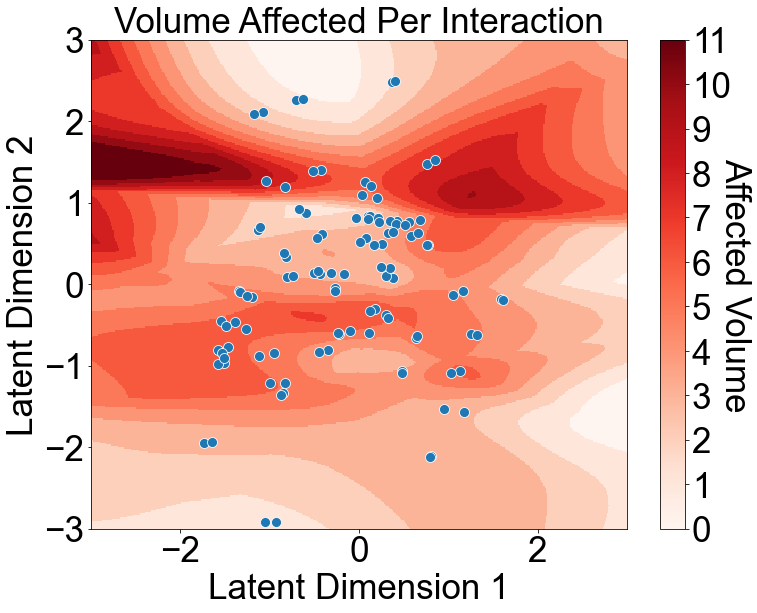

here


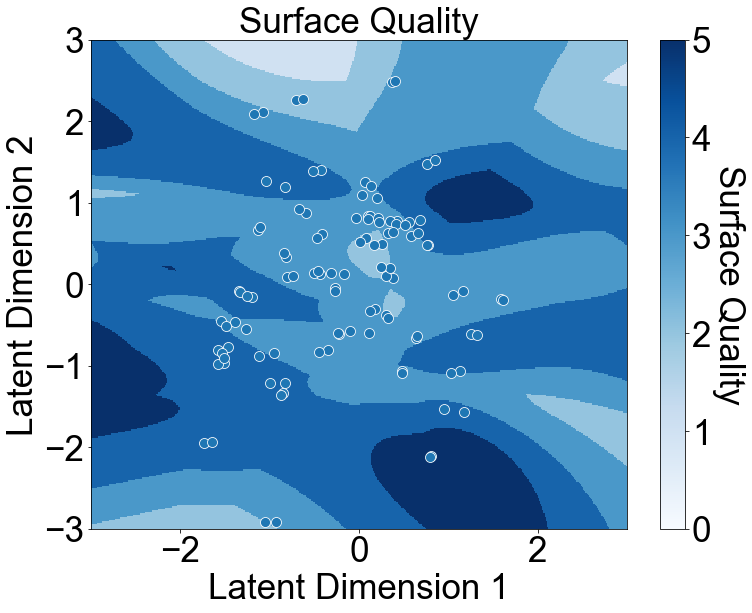

here


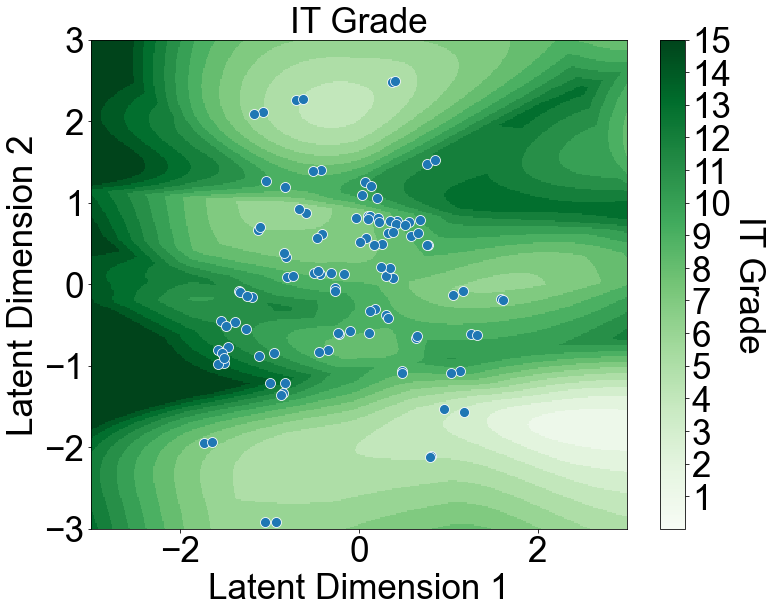

here


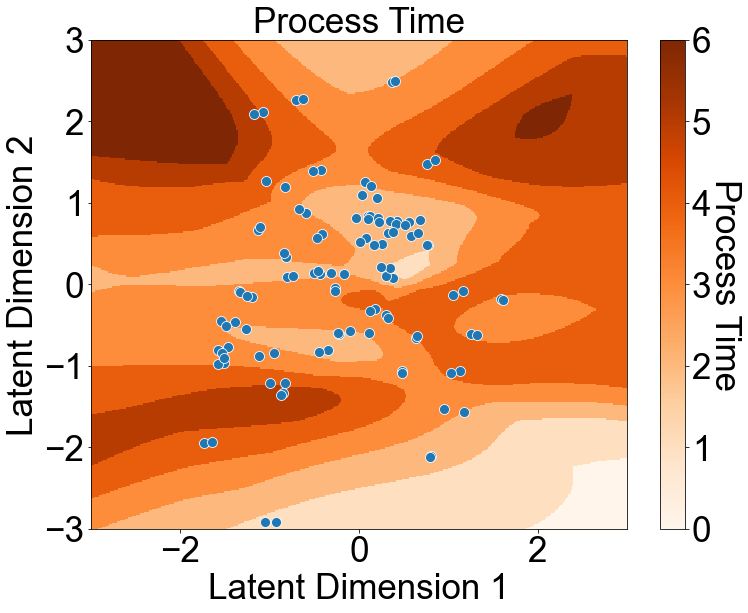

In [110]:
desired_chr = False
X_COR = 0
Y_COR = 0
XY_COR = [X_COR,Y_COR]
rounded = 1
visual(vol_per_grid,"Volume Affected Per Interaction",rounded,0,vol_affected,1, desired_chr, XY_COR)
visual(surf_qual_grid,"Surface Quality",rounded,0,surface_qual,1, desired_chr, XY_COR)
visual(IT_grade_grid,"IT Grade",rounded,0,tolerance_IT,1, desired_chr, XY_COR)
visual(time_per_grid,"Process Time",rounded,0,process_time,1, desired_chr, XY_COR)

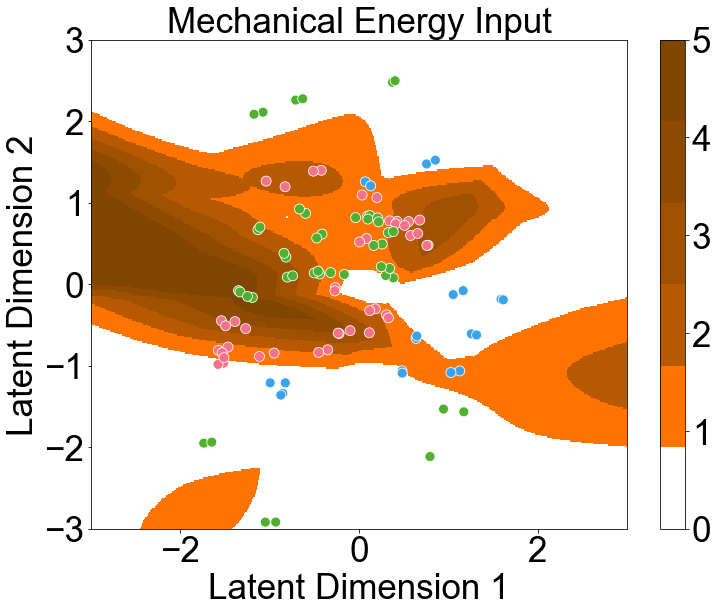

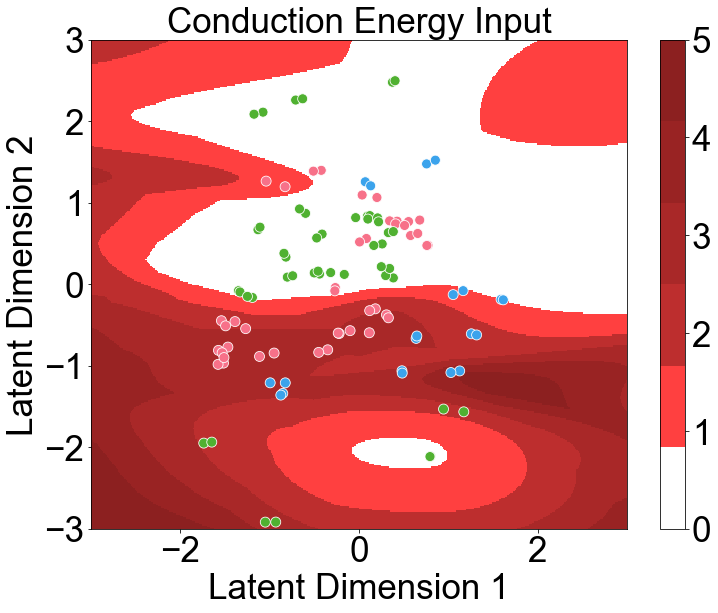

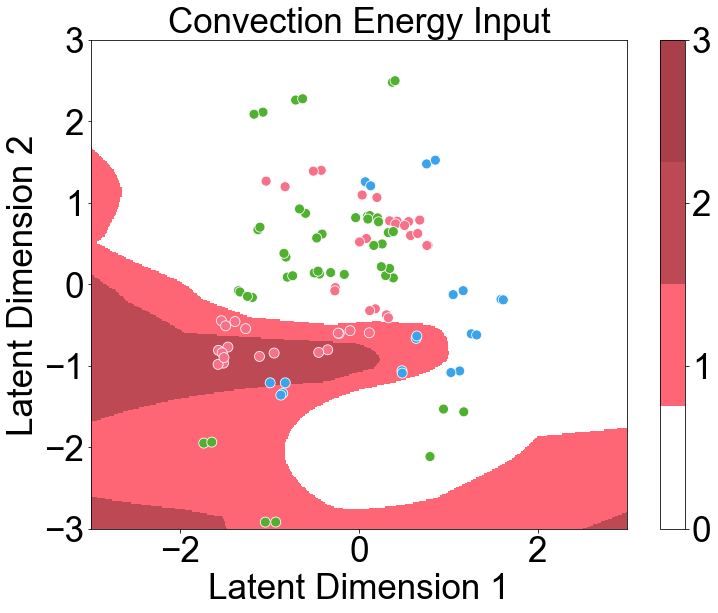

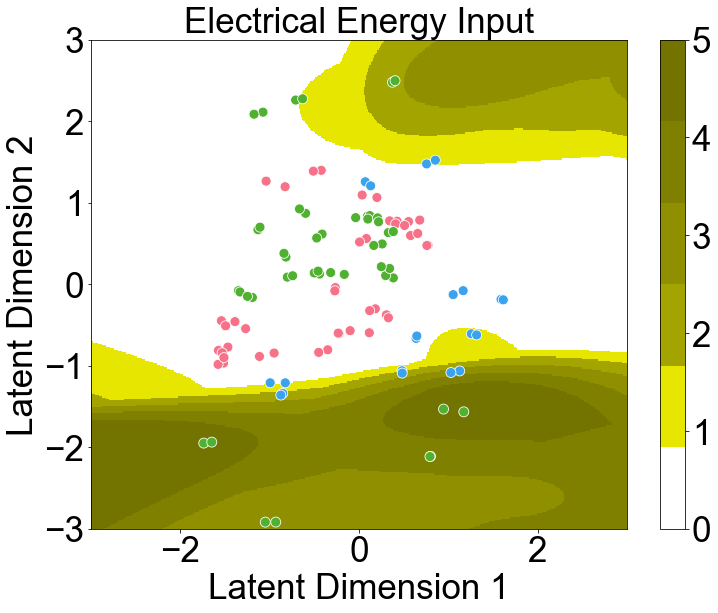

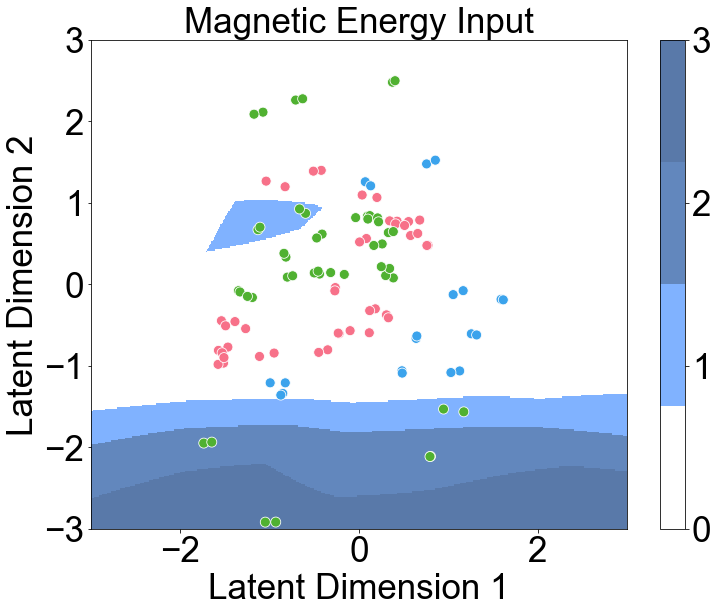

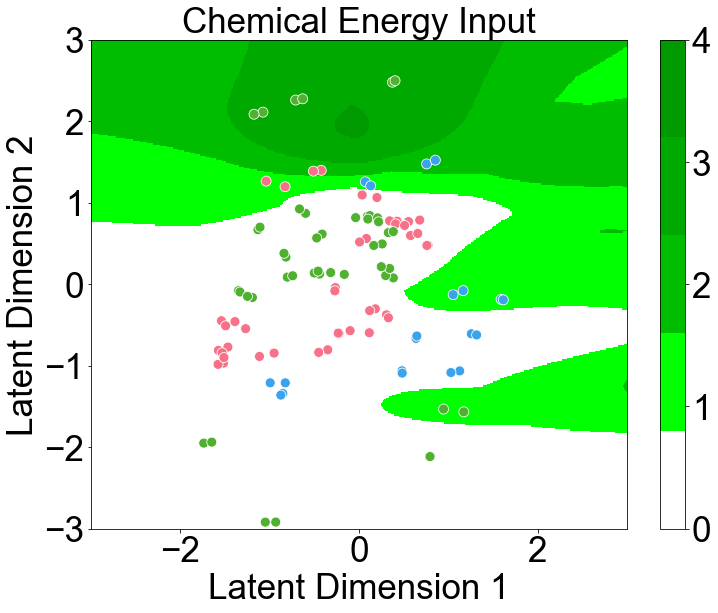

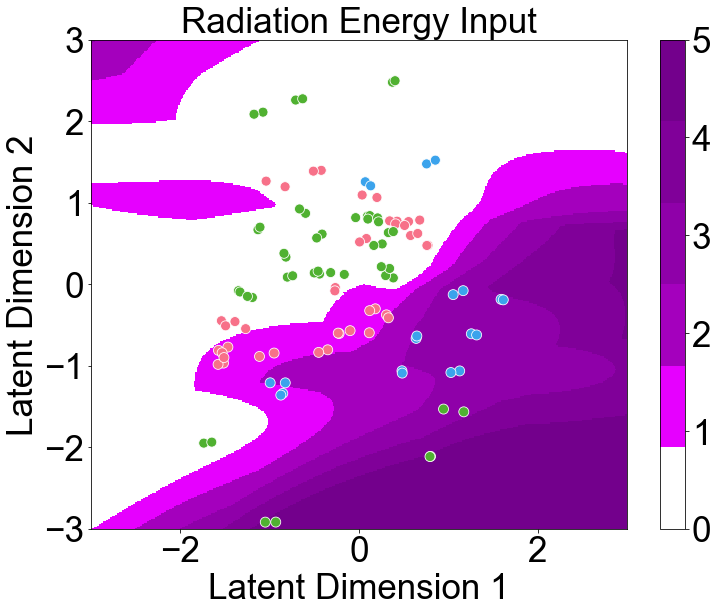

In [89]:
desired_chr = 0
zero = 1
rounded = 1
custom_color = 1
visual(mechanical_grid,"Mechanical Energy Input",rounded,custom_color,MEC,zero, desired_chr, XY_COR)
visual(conduction_grid,"Conduction Energy Input",rounded,custom_color,COND,zero, desired_chr, XY_COR)
visual(convection_grid,"Convection Energy Input",rounded,custom_color,CONV,zero, desired_chr, XY_COR)

visual(electrical_grid,"Electrical Energy Input",rounded,custom_color,ELE,zero, desired_chr, XY_COR)
visual(magnetic_grid,"Magnetic Energy Input",rounded,custom_color,MAG,zero, desired_chr, XY_COR)
visual(chemical_grid,"Chemical Energy Input",rounded,custom_color,CHE,zero, desired_chr, XY_COR)
visual(radiation_grid,"Radiation Energy Input",rounded,custom_color,RAD,zero, desired_chr, XY_COR)

here


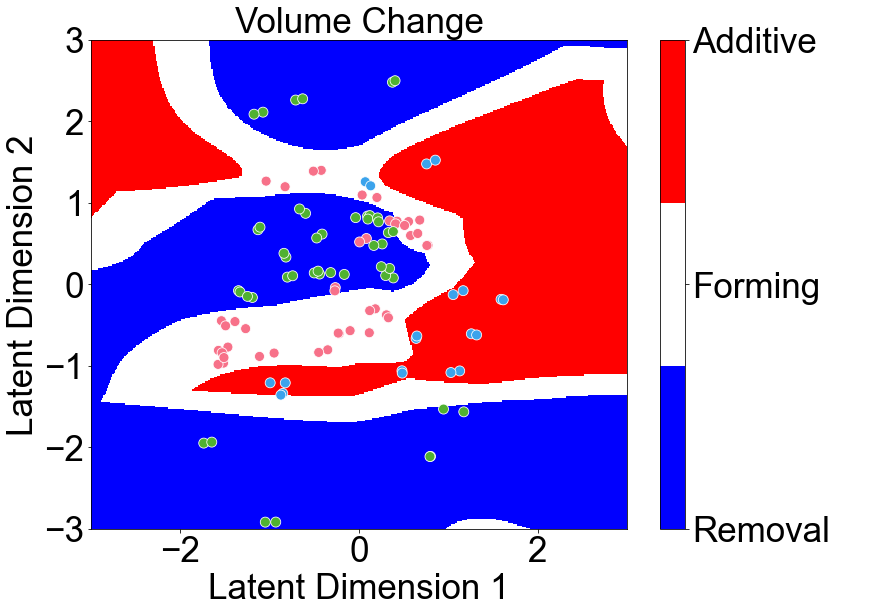

In [90]:
visual(vol_change_grid,"Volume Change",rounded,0,vol_change,1, desired_chr, XY_COR)

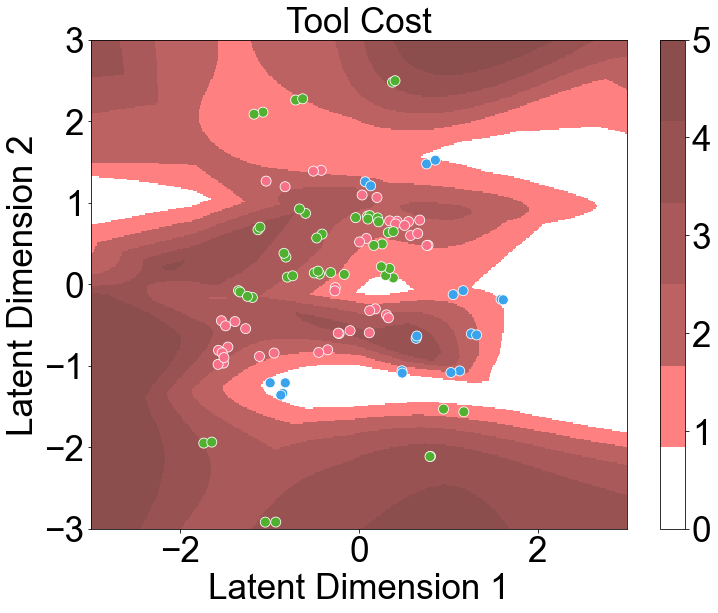

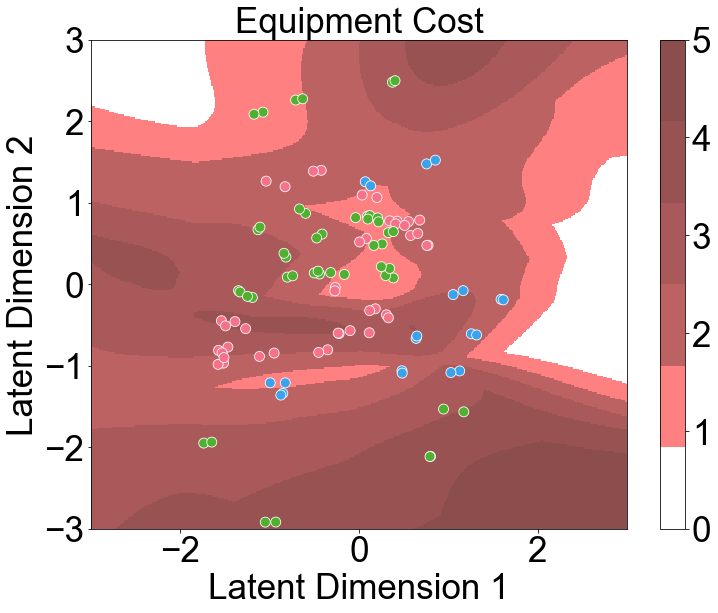

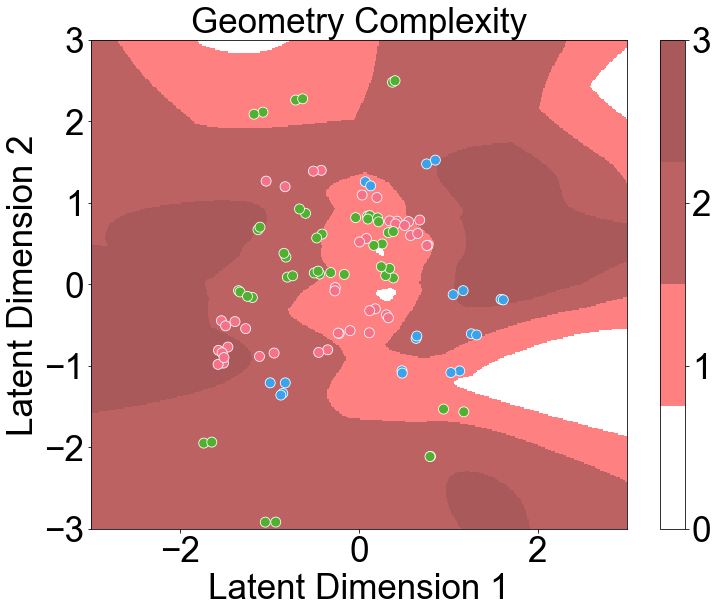

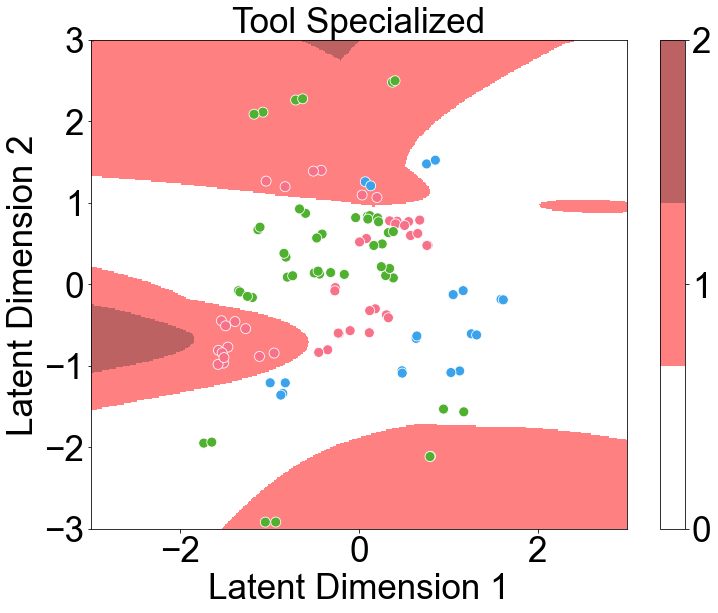

In [91]:
cost = 6
zero = 1
visual(tool_cost_grid,"Tool Cost",rounded,custom_color,tool_cost,zero,desired_chr, XY_COR)
visual(equipment_cost_grid,"Equipment Cost",rounded,custom_color,equip_cost,zero,desired_chr, XY_COR)
visual(geo_complex_grid,"Geometry Complexity",rounded,custom_color,geom_complex,zero,desired_chr, XY_COR)
visual(tool_spec_grid,"Tool Specialized",rounded,custom_color,tool_special,zero,desired_chr, XY_COR)

here


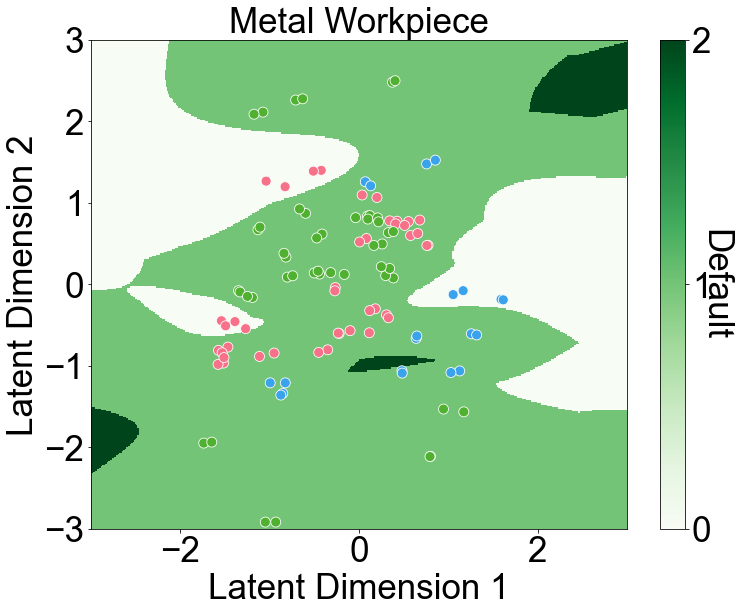

here


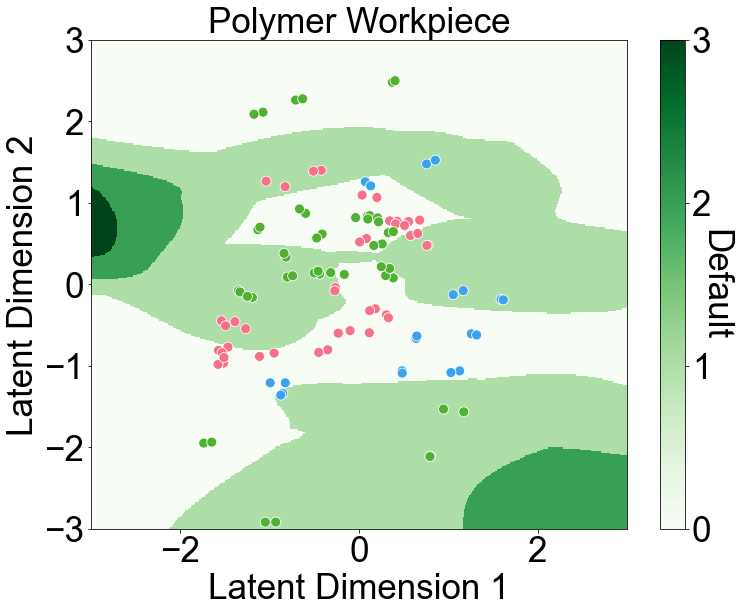

here


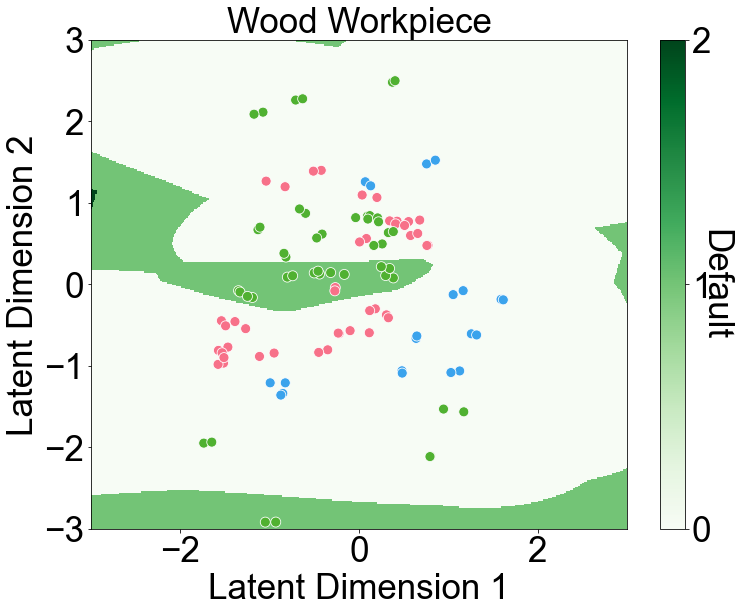

here


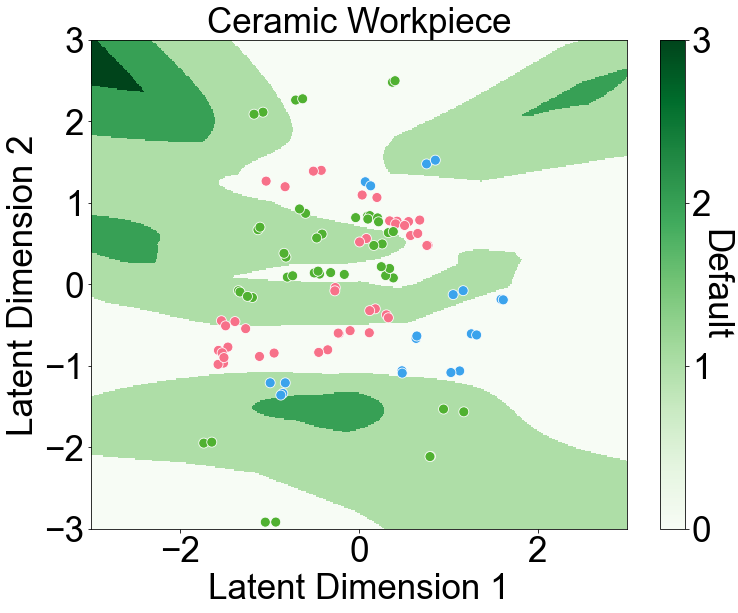

here


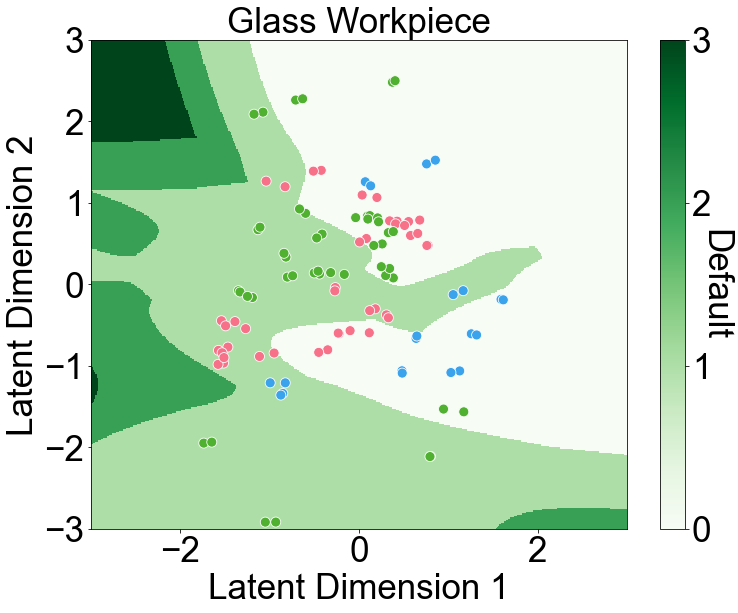

In [93]:
zero = 0
rounded = 1
custom_color = 0
visual(mat_metal_grid,"Metal Workpiece",rounded,custom_color,mat_metal,zero,desired_chr, XY_COR)
visual(mat_polymer_grid,"Polymer Workpiece",rounded,custom_color,mat_polymer,zero,desired_chr, XY_COR)
visual(mat_wood_grid,"Wood Workpiece",rounded,custom_color,mat_wood,zero,desired_chr, XY_COR)
visual(mat_ceramic_grid,"Ceramic Workpiece",rounded,custom_color,mat_ceramic,zero,desired_chr, XY_COR)
visual(mat_glass_grid,"Glass Workpiece",rounded,custom_color,mat_glass,zero,desired_chr, XY_COR)

# Search Procedure

In [94]:
def combined_energy(Mech,Cond,Conv,Elec,Magn,Chem,Radi,Vol_Change,Overlay,desired_chr, XY_COR):
    Energy_Map = 0
    ex = 1
    a = 1*ex
    b = 1*ex
    c = 1*ex
    d = 1*ex
    e = 1*ex
    f = 1*ex
    
    offset = -1000
    title = []
    
    if Mech ==1:
        Z = np.around(mechanical_grid)*b
        Z[Z<(1)] = offset
        Energy_Map += Z
        title.append('Mechanical')
    if Cond ==1:
        Z = np.around(conduction_grid)*b
        Z[Z<(1)] = offset
        Energy_Map += Z
        title.append('Conduction')
    if Conv ==1:
        Z = np.around(convection_grid)*b
        Z[Z<(1)] = offset
        Energy_Map += Z
        title.append('Convection')
    if Elec ==1:
        Energy_Map += np.around(electrical_grid)*c
        title.append('Electric')
    if Magn ==1:
        Energy_Map += np.around(magnetic_grid)*d
        title.append('Magnetic')
    if Chem ==1:
        Energy_Map += np.around(chemical_grid)*e
        title.append('Chemical')
    if Radi == 1:
        Energy_Map += np.around(radiation_grid)*f
        title.append('Radiation')
    Z = Energy_Map
    Z[Z>(1)] = 1
    
    ##### Conditions
    
    # Volume addition (2), Forming (1), or Removal (0)
    if Vol_Change ==2:
        ADD = np.around(vol_change_grid)
        ADD[ADD>2] = 0
        ADD[ADD<2] = offset
        ADD[ADD>0] = 1
        Energy_Map += ADD
        title.append('Additive')
    if Vol_Change ==1:
        FOR = np.around(vol_change_grid)
        FOR[FOR>1] = 0
        FOR[FOR<1] = offset
        FOR[FOR>0] = 1
        Energy_Map += FOR
        title.append('Transformative')
    elif Vol_Change ==0:
        REM = np.around(vol_change_grid)
        REM[REM>0] = -1
        REM[REM<0] = offset
        REM[REM>0] = 0
        Energy_Map += REM
        title.append('Removal')
        
    energy_un = unique(Energy_Map)
    VAL = Mech+Ther+Elec+Magn+Radi+Chem+Vol_Change
    Z[Z>(1)] = 1
    Z[Z<(0)] = 0
    
    multi = 100
    
    if Overlay == process_time:   
        Full_Map = Z*multi + np.round(time_per_grid)
    elif Overlay == tolerance_IT:
        Full_Map = Z*multi + np.round(IT_grade_grid)
    elif Overlay == vol_affected:
        Full_Map = Z*multi + np.round(vol_per_grid)
        
    Full_Map[Full_Map<(multi)] = 0
    CURATED_MAP = Full_Map - multi
    CURATED_MAP[CURATED_MAP<(0)] = 0
    CURATED_range = unique(CURATED_MAP)
    title = ' '.join(title)
    visual(CURATED_MAP,title,1,0,Overlay,0,desired_chr,XY_COR)

In [95]:
def space_mfg(Vol_Change,Overlay,desired_chr, XY_COR):
    Energy_Map = 0
    
    offset = -1000
    title = []
    
#     # Conduction
    Z = np.around(conduction_grid)
    Z[Z>(0)] = offset
    Z[Z>(offset)] = 0
    Energy_Map += Z
    title.append('')
    
#     Convection
    Z = np.around(convection_grid)
    Z[Z>(0)] = offset
    Z[Z>(offset)] = 0
    
    Energy_Map += Z
    title.append('MFG')
    
    Z = Energy_Map
    
    Z[Z==(0)] = 1
    Z[Z<(0)] = 0
    
    if Vol_Change ==2:
        ADD = np.around(vol_change_grid)
        ADD[ADD>2] = 0
        ADD[ADD<2] = offset
        ADD[ADD>0] = 1
        Energy_Map += ADD
        title.append('Additive Processes')
        Z[Z<(2)] = 0
        Z[Z==(2)] = 1
    if Vol_Change ==1:
        FOR = np.around(vol_change_grid)
        FOR[FOR>1] = 0
        FOR[FOR<1] = offset
        FOR[FOR>0] = 1
        Energy_Map += FOR
        title.append('Transformative Processes')
        Z[Z<(2)] = 0
        Z[Z==(2)] = 1
    elif Vol_Change ==0:
        REM = np.around(vol_change_grid)
        REM[REM>0] = -1
        REM[REM<0] = offset
        REM[REM>0] = 0
        Energy_Map += REM
        title.append('Removal Processes')
        
    multi = 100
    
    if Overlay == process_time:   
        Full_Map = Z*multi + np.round(time_per_grid)
    elif Overlay == tolerance_IT:
        Full_Map = Z*multi + np.round(IT_grade_grid)
    elif Overlay == vol_affected:
        Full_Map = Z*multi + np.round(vol_per_grid)
    
    Full_Map[Full_Map<(multi)] = 0
    CURATED_MAP = Full_Map - multi
    CURATED_MAP[CURATED_MAP<(0)] = 0
    CURATED_range = unique(CURATED_MAP)
    title = ' '.join(title)
    visual(CURATED_MAP,title,1,0,Overlay,0,desired_chr,XY_COR)    

In [96]:
np.max(IT_grade_grid)

22.881841235322238

here
Desired characterisitc not available
[ 3.37128595 -0.23137846  0.10242768 -0.21958223  0.03852786 -0.13523291
  0.07769105  1.97956651  1.43945529  7.16038404  0.03873338  4.8377621
 11.53720582  0.76616924  0.49362327 -0.01541547 -0.28110188 -0.19452629
  2.30562333  2.68053674  2.01035727]
[ 3. -0.  0. -0.  0. -0.  0.  2.  1.  7.  0.  5. 12.  1.  0. -0. -0. -0.
  2.  3.  2.]
Process 1. ----------------
MEC:   	3.0
COND:   	-0.0
CONV:   	0.0
ELE:   	-0.0
MAG:   	0.0
CHE:   	-0.0
RAD:   	0.0
TIME_1:   	10.0 s
VOL_CHANGE:   	1.0
VOL_1:   	10000.0 mm³
TOOL_SPE:   	0.0
SURFQ_1:   	100000.0 nm
IT_1:   	12.0
MET:   	1.0
POLYMER:   	0.0
WOOD:   	-0.0
CERAMIC:   	-0.0
GLASS:   	-0.0
GEOM_COM:   	2.0
TOOL_COST:   	3.0
EQUIP_COST:   	2.0
[ 1.27722840e+00 -8.12317580e-02 -1.43356265e-01  2.23941689e-01
 -3.26245990e-02  2.76658506e+00  6.58983455e-02  3.65259683e+00
  6.22366224e-01  4.95313668e+00  1.16918977e+00  3.34973420e+00
  6.49972890e+00  2.93215660e-01  9.78561729e-01  5.17968605e

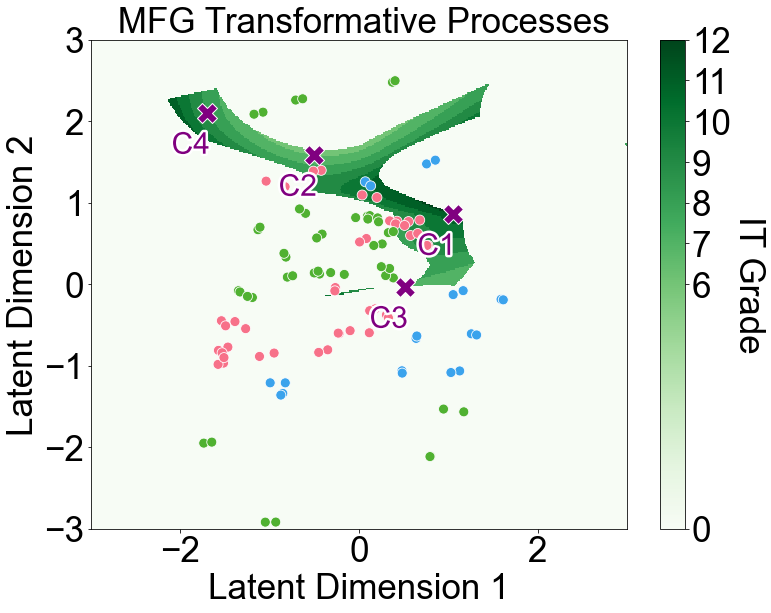

here
Desired characterisitc not available
[ 2.8099561  -0.19625618  0.09214057 -0.18665742 -0.0738278   0.39187003
  0.14881936  3.00745625  2.22972516  9.5031606   0.25287659  5.19961357
 13.06206404  0.64150203  0.85476071 -0.05209349 -0.02941036  0.02999088
  2.71577242  1.98056853  2.10888279]
[ 3. -0.  0. -0. -0.  0.  0.  3.  2. 10.  0.  5. 13.  1.  1. -0. -0.  0.
  3.  2.  2.]
Process 1. ----------------
MEC:   	3.0
COND:   	-0.0
CONV:   	0.0
ELE:   	-0.0
MAG:   	-0.0
CHE:   	0.0
RAD:   	0.0
TIME_1:   	100.0 s
VOL_CHANGE:   	2.0
VOL_1:   	10000000.0 mm³
TOOL_SPE:   	0.0
SURFQ_1:   	100000.0 nm
IT_1:   	13.0
MET:   	1.0
POLYMER:   	1.0
WOOD:   	-0.0
CERAMIC:   	-0.0
GLASS:   	0.0
GEOM_COM:   	3.0
TOOL_COST:   	2.0
EQUIP_COST:   	2.0
[-0.14905921 -0.38113383 -0.45648072 -0.98412856 -0.15521089  1.02116599
  4.06661174  3.79119891  2.41473718  1.4941446  -0.21006308  3.1815491
  7.40619829  0.19523297  0.83737854  0.32867027 -0.07477302  0.09575015
  2.33246248 -1.53775684 -0.027098

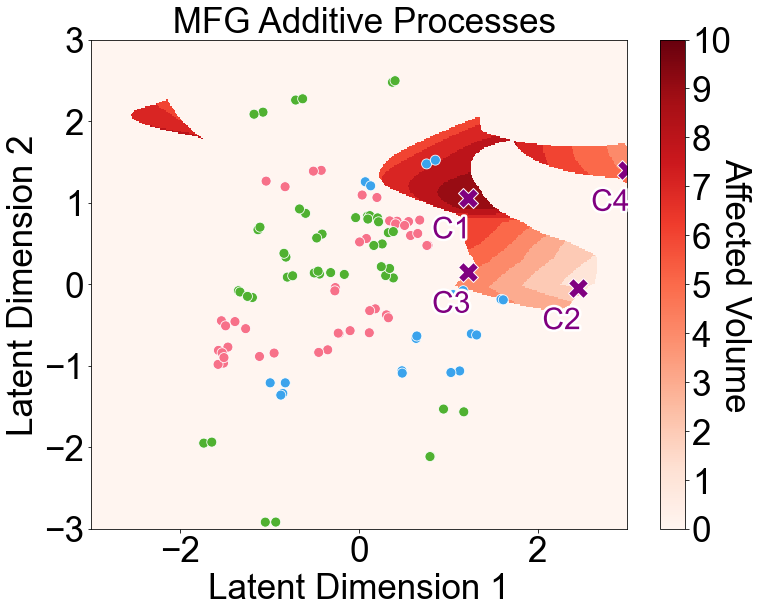

here
Desired characterisitc not available
[ 0.47860165 -0.13624104 -0.1001883  -0.03384247 -0.00791544  2.80123359
  0.06784652  4.54190475  0.49724157  3.96504654  1.03755061  3.30990043
  6.24302949  0.42798025  0.49776808 -0.05452843  0.69825176  0.76664411
  1.62899946  0.8479141   1.23200612]
[ 0. -0. -0. -0. -0.  3.  0.  5.  0.  4.  1.  3.  6.  0.  0. -0.  1.  1.
  2.  1.  1.]
Process 1. ----------------
MEC:   	0.0
COND:   	-0.0
CONV:   	-0.0
ELE:   	-0.0
MAG:   	-0.0
CHE:   	3.0
RAD:   	0.0
TIME_1:   	10000.0 s
VOL_CHANGE:   	0.0
VOL_1:   	10.0 mm³
TOOL_SPE:   	1.0
SURFQ_1:   	1000.0 nm
IT_1:   	6.0
MET:   	0.0
POLYMER:   	0.0
WOOD:   	-0.0
CERAMIC:   	1.0
GLASS:   	1.0
GEOM_COM:   	2.0
TOOL_COST:   	1.0
EQUIP_COST:   	1.0
[ 0.81370528 -0.22061954  0.0631031   0.1144274  -0.06077624  0.1486166
  0.04485661  1.48386129  0.05240867  3.00272409  0.20030256  2.81346085
  7.76125951  1.08567436  0.49811383  0.98990482 -0.17921538  0.15134511
  0.93321942  0.53405157  0.88366853]
[ 1

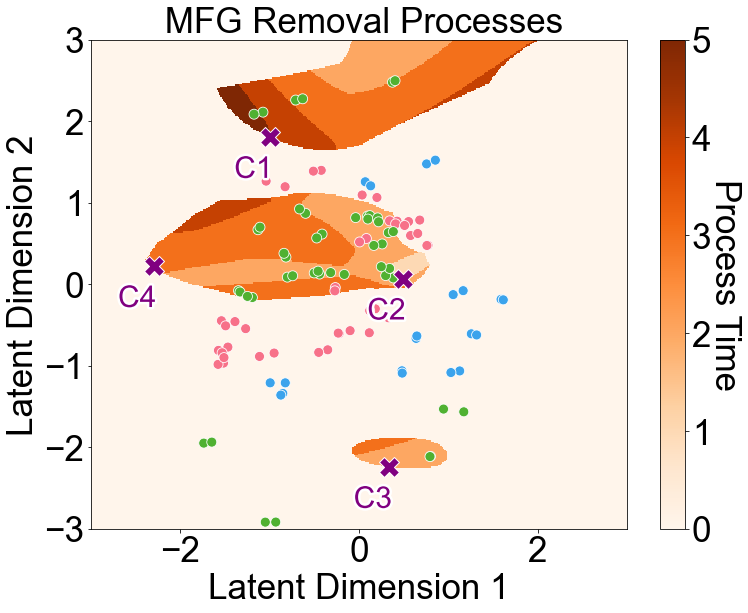

In [97]:
Vol_Change = 2
# X_COR = 1.2
X_COR = -1.7
Y_COR = 2.1
XY_COR = [X_COR,Y_COR]
space_mfg(1,tolerance_IT,13,XY_COR)
# X_COR = -2.2
X_COR = 3.0
Y_COR = 1.4
# Y_COR = 2
XY_COR = [X_COR,Y_COR]
space_mfg(2,vol_affected,12,XY_COR)
# vol_affected
X_COR = -2.3
Y_COR = 0.22
XY_COR = [X_COR,Y_COR]
space_mfg(0,process_time,12,XY_COR)


In [98]:
# XY_COR = [1.34835,-2.253228]

# new_processes = model_decoder(torch.tensor(XY_COR, dtype=torch.float).to(device)).detach().cpu().numpy()
# temp_features = np.zeros_like(feature_index_array,dtype=float)
# for e in range(len(feature_index_array)):  
#     temp_features[e] = new_processes[e] * w[e]
#     temp_features[e] = norm_element_inv(temp_features[e], x3, e)
# print(temp_features)

[-0.08135966  0.8175452   0.4220974   3.64085307  2.33088076 -0.00850018
  6.4191763   1.29214168  0.09742419  3.34262092  1.14028788  5.11639534
  4.66666898  1.00488192  1.40849999  0.18571604  0.99825074  1.1524806
  2.44739017  4.06689082  4.58915773]
